In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
import json
import time
import os
import tensorflow as tf
import tensorflow_probability as tfp
import pickle
import string
import scipy.stats as st
import tensorflow as tf
import sys

# Need in order to call models from models.py in directory above
sys.path.insert(1, '/Users/milesturpin/latent_variable_nn')

tfd = tfp.distributions

InteractiveShell.ast_node_interactivity = 'all'
%config InlineBackend.figure_format = 'retina'

/Users/milesturpin/miniconda3/envs/latent/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/milesturpin/miniconda3/envs/latent/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/milesturpin/miniconda3/envs/latent/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/milesturpin/minico

In [3]:
data_size = 'small'
x_train = np.load('../data/femnist/{data_size}/x_train.npy'.format(data_size=data_size))
y_train = np.load('../data/femnist/{data_size}/y_train.npy'.format(data_size=data_size))
gid_train = np.load('../data/femnist/{data_size}/gid_train.npy'.format(data_size=data_size))
x_test = np.load('../data/femnist/{data_size}/x_test.npy'.format(data_size=data_size))
y_test = np.load('../data/femnist/{data_size}/y_test.npy'.format(data_size=data_size))
gid_test = np.load('../data/femnist/{data_size}/gid_test.npy'.format(data_size=data_size))

In [5]:
writer_df = pd.DataFrame(np.stack([y_train, gid_train]).T, 
                         columns=['label', 'writer'])
distribution_of_labels = writer_df.groupby('writer')['label'].value_counts().unstack().fillna(0)
samples_per_writer = writer_df.groupby('writer').size().rename('num_train_samples')
samples_weights = samples_per_writer.transform(lambda x: x/x.sum())

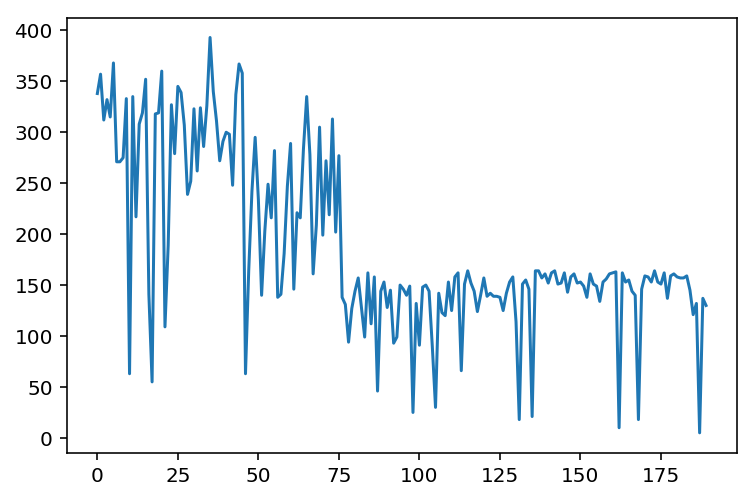

In [6]:
plt.plot(samples_per_writer)

# new way

### review all experiments

In [7]:
import re 
results_df_list = []
hyperparams = []
mod_hyperparams = []
directories = !cd ../experiments/femnist; ls -d -- */
for exp_dir in directories:
    exp_path = os.path.join('..','experiments', 'femnist', exp_dir)
    
    # Merge training stats csv's
    training_stats_files = !cd {exp_path}; ls -d -- training_stats*
    df_list = []
    try:
        for file in training_stats_files:
            df_list.append(pd.read_csv(os.path.join(exp_path, file)))
        df = pd.concat(df_list)
        df = df.set_index(['epoch', 'gid'])
        results_df_list.append(df)
    except:
        pass
    
    # load hyperparam json file
    with open(os.path.join(exp_path, 'hyperparams.json'),'r') as f:
        hyper = json.load(f)
        hyperparams.append(hyper)
        mod_hyper = hyper.copy()
        # clean up date string
        mod_hyper['date'] = re.sub('_',' ', re.sub('/','', re.sub('2019-','',exp_dir)))
        # Need this so can groupby later
        mod_hyper['z_dim'] = str(mod_hyper['z_dim'])
        if mod_hyper['seed'] is None:
            mod_hyper['seed']=-1
        if mod_hyper['description'] is None:
            mod_hyper['description']=-1
        mod_hyperparams.append(mod_hyper)
    
config_df = pd.concat((pd.Series(param_dict) for param_dict in mod_hyperparams), axis=1).T

/Users/milesturpin/miniconda3/envs/latent/lib/python3.5/site-packages/ipykernel_launcher.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [8]:
temp = config_df.drop(['seed', 'testing', 'print_freq'],1)
# Move description to end
display(temp[[col for col in temp if col not in ['description']] + ['description']])

,batch_size,both,data_size,dataset,date,eval_every,latent_config,latent_space,lr,model_size,num_epochs,variational,z_dim,description
0,1000,NaN,large,femnist,08-01 23-18-31,1,NaN,True,0.001,large,5,True,[10],"new cnn architecture, took out dropout"
1,200,NaN,large,femnist,08-02 00-46-16,1,NaN,False,0.001,large,5,False,[10],urg ok essentially trying original architectur...
2,200,NaN,large,femnist,08-02 02-28-10,1,NaN,True,0.001,large,5,True,[20],trying this with latent vars
3,1000,NaN,small,femnist,08-02 21-47-20,1,NaN,False,0.01,small,20,False,[20],-1
4,20,NaN,small,femnist,08-02 23-49-21,1,NaN,False,0.01,test,10,False,[20],10k data pts
5,100,NaN,small,femnist,08-02 23-51-07,1,NaN,False,0.01,test,10,False,[20],10k data pts
6,100,NaN,small,femnist,08-02 23-52-26,1,NaN,False,0.01,test,10,False,[20],full data
7,1000,NaN,small,femnist,08-02 23-55-41,1,NaN,False,0.01,test,20,False,[20],full data
8,1000,NaN,small,femnist,08-03 00-06-13,1,NaN,False,0.01,small,20,False,[20],verify
9,1000,NaN,small,femnist,08-03 00-06-59,1,NaN,False,0.01,small,20,False,[20],verify


In [9]:
directories = !cd ../experiments/femnist; ls -d -- */

In [7]:
#next(os.walk('./experiments/femnist'))

In [507]:
directories = directories[2:3]

In [10]:
directories = directories[-14:]

In [11]:
results_df_list = []
hyperparams = []
mod_hyperparams = []
for exp_dir in directories:
    exp_path = os.path.join('..','experiments', 'femnist', exp_dir)
    
    # Merge training stats csv's
    training_stats_files = !cd {exp_path}; ls -d -- training_stats*
    df_list = []
    try:
        for file in training_stats_files:
            df_list.append(pd.read_csv(os.path.join(exp_path, file)))
        df = pd.concat(df_list)
        df = df.set_index(['epoch', 'gid'])
        results_df_list.append(df)
    except:
        pass
    
    # load hyperparam json file
    with open(os.path.join(exp_path, 'hyperparams.json'),'r') as f:
        hyper = json.load(f)
        mod_hyper = hyper.copy()
        hyperparams.append(hyper)
        # Need this so can groupby later
        mod_hyper['z_dim'] = str(mod_hyper['z_dim'])
        # clean up date string
        mod_hyper['date'] = re.sub('_',' ', re.sub('/','', re.sub('2019-','',exp_dir)))
        
        if mod_hyper['seed'] is None:
            mod_hyper['seed']=-1
        if mod_hyper['description'] is None:
            mod_hyper['description']=-1
        try:
            mod_hyper['latent_config']
        except:
            mod_hyper['latent_config']='NA'
        mod_hyperparams.append(mod_hyper)
    
config_df = pd.concat((pd.Series(param_dict) for param_dict in mod_hyperparams), axis=1).T


'none'

In [12]:
temp = config_df.drop(['seed', 'testing', 'print_freq'],1)
# Move description to end
display(temp[[col for col in temp if col not in ['description']] + ['description']])

,batch_size,both,data_size,dataset,date,eval_every,latent_config,latent_space,lr,model_size,num_epochs,variational,z_dim,description
0,1000,False,small,femnist,08-04 21-23-46,3,none,True,0.01,small,40,True,"[4, 16]",bias latent
1,1000,False,small,femnist,08-04 21-59-05,3,NA,False,0.004,small,30,False,"[4, 16]",exp 1750: no latent
2,1000,False,small,femnist,08-04 22-00-43,3,NA,True,0.004,small,30,True,"[4, 16]",one latents
3,1000,True,small,femnist,08-04 22-01-57,3,NA,True,0.004,small,30,True,"[4, 16]",both latents
4,1000,False,small,femnist,08-04 22-44-50,3,NA,False,0.004,small,40,False,"[16, 16]",No latent
5,1000,False,small,femnist,08-04 22-46-43,3,NA,False,0.004,small,40,False,"[16, 16]",No latent
6,1000,False,small,femnist,08-04 22-48-36,3,NA,False,0.004,small,40,False,"[16, 16]",No latent
7,1000,False,small,femnist,08-04 22-50-29,3,NA,True,0.004,small,40,True,"[16, 16]",One latent
8,1000,False,small,femnist,08-04 22-53-28,3,NA,True,0.004,small,40,True,"[16, 16]",One latent
9,1000,False,small,femnist,08-04 22-56-30,3,NA,True,0.004,small,40,True,"[16, 16]",One latent


,batch_size,both,data_size,dataset,date,eval_every,latent_config,latent_space,lr,model_size,num_epochs,variational,z_dim,description
0,1000,False,small,femnist,08-04 21-23-46,3,none,True,0.01,small,40,True,"[4, 16]",bias latent
1,1000,False,small,femnist,08-04 21-59-05,3,NA,False,0.004,small,30,False,"[4, 16]",exp 1750: no latent
2,1000,False,small,femnist,08-04 22-00-43,3,NA,True,0.004,small,30,True,"[4, 16]",one latents
3,1000,True,small,femnist,08-04 22-01-57,3,NA,True,0.004,small,30,True,"[4, 16]",both latents
4,1000,False,small,femnist,08-04 22-44-50,3,NA,False,0.004,small,40,False,"[16, 16]",No latent
5,1000,False,small,femnist,08-04 22-46-43,3,NA,False,0.004,small,40,False,"[16, 16]",No latent
6,1000,False,small,femnist,08-04 22-48-36,3,NA,False,0.004,small,40,False,"[16, 16]",No latent
7,1000,False,small,femnist,08-04 22-50-29,3,NA,True,0.004,small,40,True,"[16, 16]",One latent
8,1000,False,small,femnist,08-04 22-53-28,3,NA,True,0.004,small,40,True,"[16, 16]",One latent
9,1000,False,small,femnist,08-04 22-56-30,3,NA,True,0.004,small,40,True,"[16, 16]",One latent


Weighted test accuracy: 0.835, 50th percentile 0.842, 10th percentile: 0.688, 90th percentile: 0.969
Weighted test accuracy: 0.831, 50th percentile 0.833, 10th percentile: 0.648, 90th percentile: 0.968
Weighted test accuracy: 0.86, 50th percentile 0.875, 10th percentile: 0.713, 90th percentile: 1.0
Weighted test accuracy: 0.864, 50th percentile 0.875, 10th percentile: 0.722, 90th percentile: 1.0
Weighted test accuracy: 0.823, 50th percentile 0.824, 10th percentile: 0.647, 90th percentile: 0.968
Weighted test accuracy: 0.816, 50th percentile 0.821, 10th percentile: 0.667, 90th percentile: 0.978
Weighted test accuracy: 0.818, 50th percentile 0.825, 10th percentile: 0.667, 90th percentile: 0.953
Weighted test accuracy: 0.864, 50th percentile 0.875, 10th percentile: 0.719, 90th percentile: 1.0
Weighted test accuracy: 0.857, 50th percentile 0.87, 10th percentile: 0.727, 90th percentile: 1.0
Weighted test accuracy: 0.858, 50th percentile 0.875, 10th percentile: 0.706, 90th percentile: 1.0
We

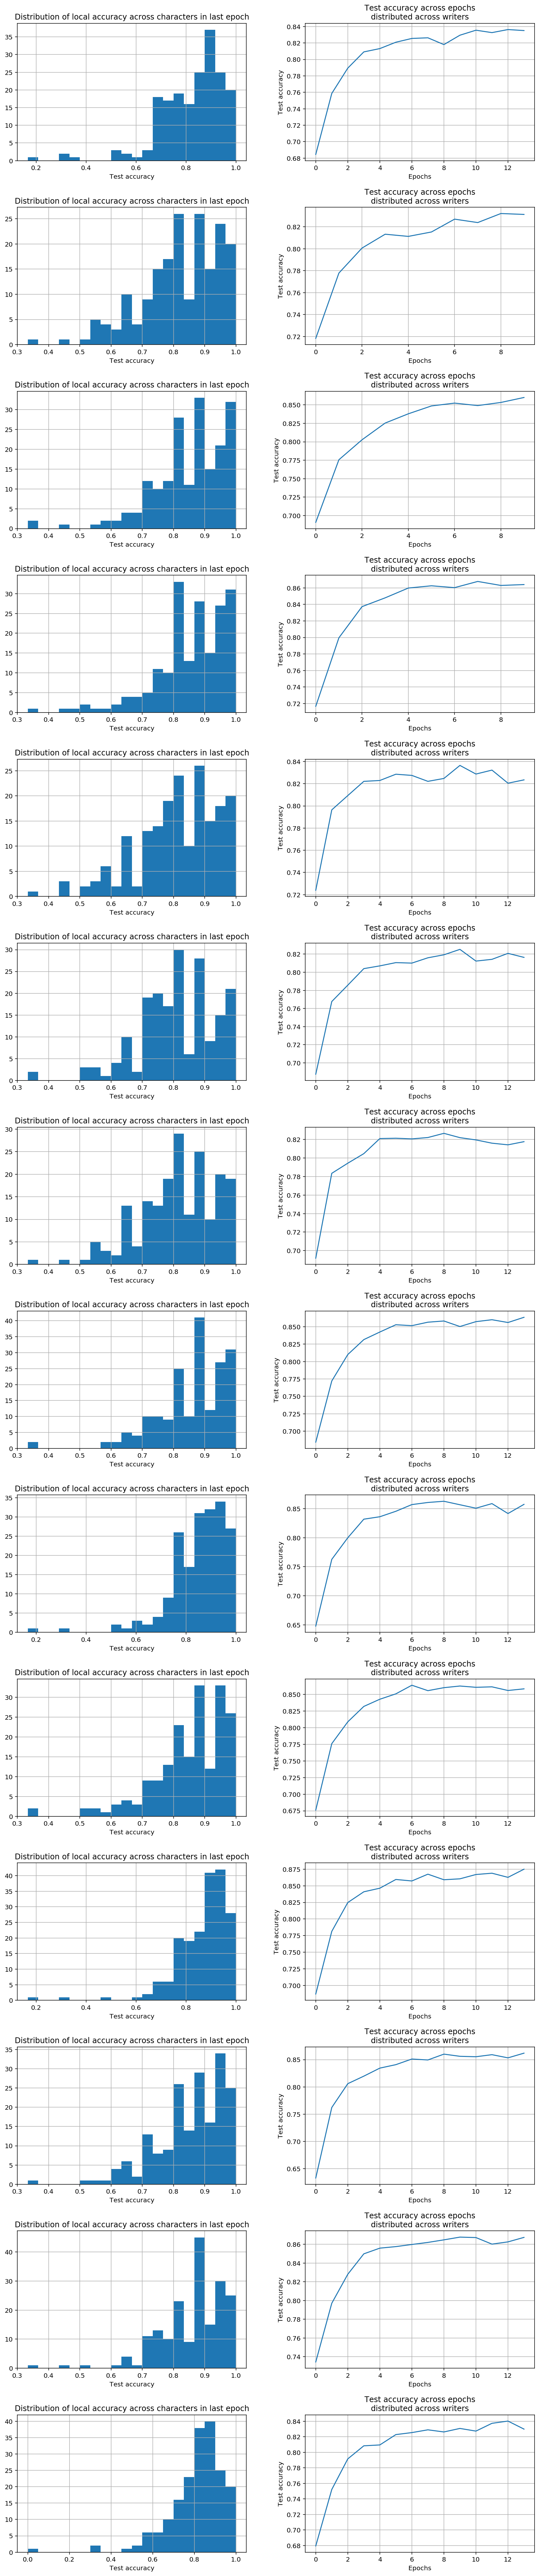

In [13]:
num_configs = len(directories)
plt.figure(figsize=(12,num_configs*4))

temp = config_df.drop(['seed', 'testing', 'print_freq'],1)
# Move description to end
display(temp[[col for col in temp if col not in ['description']] + ['description']])

for i in range(num_configs):
    train_stats = results_df_list[i]
    fed_acc_df = train_stats['test_acc'].unstack()
    
    plt.subplot(num_configs,2,2*i+1)
    fed_acc_df.tail(1).squeeze().hist(bins=20)
    plt.title('Distribution of local accuracy across characters in last epoch')
    plt.xlabel('Test accuracy')

    get_percentile = lambda perc: np.percentile(
        sorted(fed_acc_df.tail(1).squeeze().dropna().values), perc)
    stats = [
        round(np.dot(fed_acc_df.tail(1).squeeze().values, samples_weights.values),3),
        round(get_percentile(50),3),
        round(get_percentile(10),3),
        round(get_percentile(90),3)]
    print('Weighted test accuracy: {}, 50th percentile {}, 10th percentile: {}, 90th percentile: {}'.format(*stats))
    plt.subplot(num_configs,2,2*i+2)
    plt.plot(
        #fed_acc_df.apply(lambda s: np.percentile(s.dropna(), 50), axis=1).values
        fed_acc_df.apply(lambda s: np.dot(s.values, samples_weights.values), axis=1).values
    )
#     plt.fill_between(range(len(fed_acc_df)), 
#                      fed_acc_df.apply(lambda s: np.percentile(s.dropna(), 90), axis=1).values,
#                      fed_acc_df.apply(lambda s: np.percentile(s.dropna(), 10), axis=1).values,
#                      alpha=0.1, facecolor='C0')
    
#     plt.fill_between(range(len(fed_acc_df)), 
#                      fed_acc_df.apply(lambda s: np.percentile(s.dropna(), 75), axis=1).values,
#                      fed_acc_df.apply(lambda s: np.percentile(s.dropna(), 25), axis=1).values,
#                      alpha=0.2, facecolor='C0')

    plt.title('Test accuracy across epochs\n'
              'distributed across writers')
    plt.xlabel('Epochs')
    plt.ylabel('Test accuracy')
    plt.grid(True)

plt.tight_layout();

,batch_size,both,data_size,dataset,date,eval_every,latent_config,latent_space,lr,model_size,num_epochs,variational,z_dim,description
0,1000,False,small,femnist,08-04 21-23-46,3,none,True,0.01,small,40,True,"[4, 16]",bias latent
1,1000,False,small,femnist,08-04 21-59-05,3,NA,False,0.004,small,30,False,"[4, 16]",exp 1750: no latent
2,1000,False,small,femnist,08-04 22-00-43,3,NA,True,0.004,small,30,True,"[4, 16]",one latents
3,1000,True,small,femnist,08-04 22-01-57,3,NA,True,0.004,small,30,True,"[4, 16]",both latents
4,1000,False,small,femnist,08-04 22-44-50,3,NA,False,0.004,small,40,False,"[16, 16]",No latent
5,1000,False,small,femnist,08-04 22-46-43,3,NA,False,0.004,small,40,False,"[16, 16]",No latent
6,1000,False,small,femnist,08-04 22-48-36,3,NA,False,0.004,small,40,False,"[16, 16]",No latent
7,1000,False,small,femnist,08-04 22-50-29,3,NA,True,0.004,small,40,True,"[16, 16]",One latent
8,1000,False,small,femnist,08-04 22-53-28,3,NA,True,0.004,small,40,True,"[16, 16]",One latent
9,1000,False,small,femnist,08-04 22-56-30,3,NA,True,0.004,small,40,True,"[16, 16]",One latent


Config 0: test accuracy = 0.835, 50th percentile = 0.842, 10th percentile = 0.688, 90th percentile = 0.969
Config 1: test accuracy = 0.831, 50th percentile = 0.833, 10th percentile = 0.648, 90th percentile = 0.968
Config 2: test accuracy = 0.86, 50th percentile = 0.875, 10th percentile = 0.713, 90th percentile = 1.0
Config 3: test accuracy = 0.864, 50th percentile = 0.875, 10th percentile = 0.722, 90th percentile = 1.0
Config 4: test accuracy = 0.823, 50th percentile = 0.824, 10th percentile = 0.647, 90th percentile = 0.968
Config 5: test accuracy = 0.816, 50th percentile = 0.821, 10th percentile = 0.667, 90th percentile = 0.978
Config 6: test accuracy = 0.818, 50th percentile = 0.825, 10th percentile = 0.667, 90th percentile = 0.953
Config 7: test accuracy = 0.864, 50th percentile = 0.875, 10th percentile = 0.719, 90th percentile = 1.0
Config 8: test accuracy = 0.857, 50th percentile = 0.87, 10th percentile = 0.727, 90th percentile = 1.0
Config 9: test accuracy = 0.858, 50th percentil

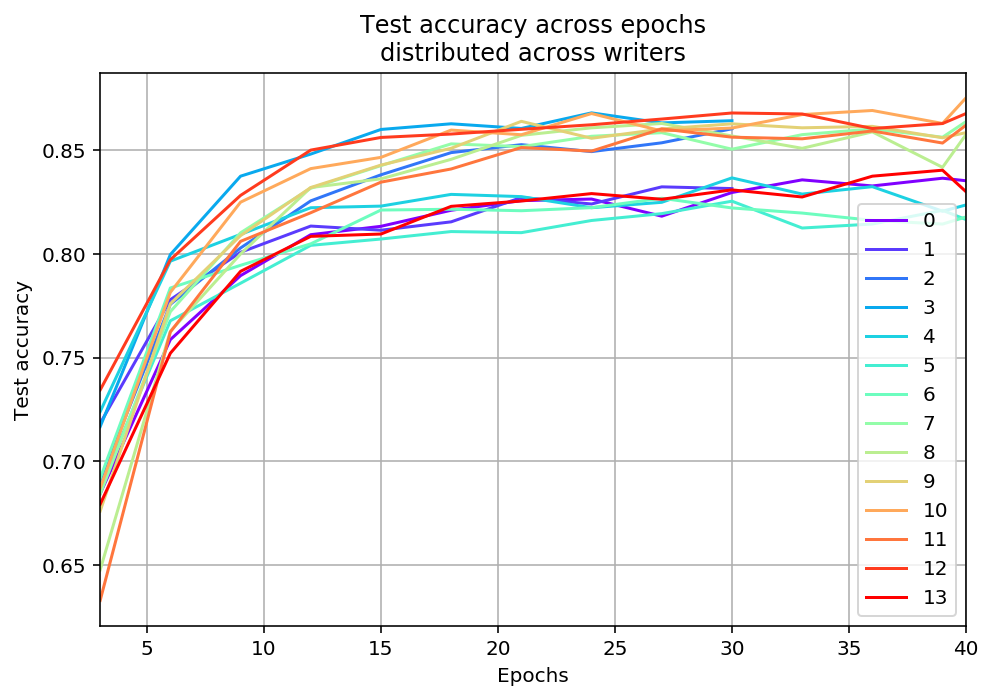

In [14]:
num_configs = len(directories)

temp = config_df.drop(['seed', 'testing', 'print_freq'],1)
# Move description to end
display(temp[[col for col in temp if col not in ['description']] + ['description']])

mean_accs = []
for i, train_stats in enumerate(results_df_list):
    fed_acc_df = train_stats['test_acc'].unstack()
    mean_acc = fed_acc_df.apply(lambda s: np.dot(s.values, samples_weights.values), axis=1)
    mean_accs.append(mean_acc)

    get_percentile = lambda perc: np.percentile(
        sorted(fed_acc_df.tail(1).squeeze().dropna().values), perc)
    stats = [
        round(np.dot(fed_acc_df.tail(1).squeeze().values, samples_weights.values),3),
        round(get_percentile(50),3),
        round(get_percentile(10),3),
        round(get_percentile(90),3)]
    print('Config {}: test accuracy = {}, 50th percentile = {}, 10th percentile = {}, 90th percentile = {}'.format(i, *stats))
    
ax = pd.concat(mean_accs, axis=1).plot(figsize=(7,5), cmap='rainbow')
#for i in range(4):
#    pd.concat(mean_accs, axis=1).reset_index().plot.scatter(x='epoch', y=i,figsize=(7,5), ax=ax)
plt.title('Test accuracy across epochs\ndistributed across writers')
plt.xlabel('Epochs')
plt.ylabel('Test accuracy')
plt.grid(True)
plt.tight_layout();

In [15]:
mean_acc_arr = pd.concat(mean_accs, axis=1).loc[40].values
mean_acc_arr[:3].mean(), mean_acc_arr[3:6].mean(), mean_acc_arr[6:9].mean()

(nan, nan, 0.8461818168695078)

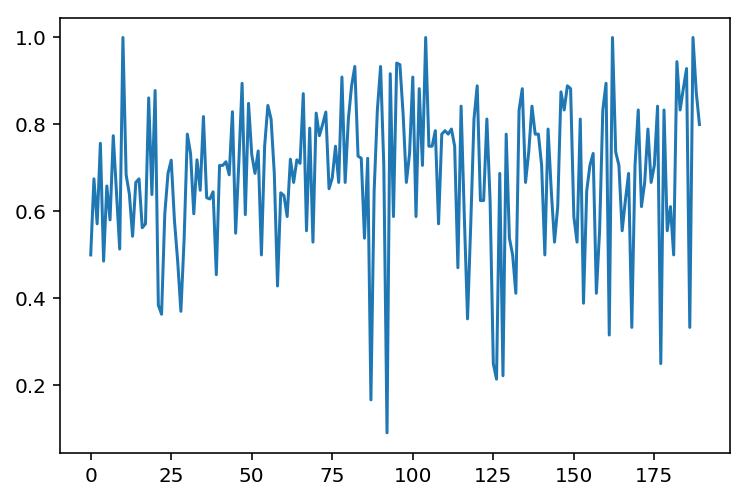

In [16]:
plt.plot(fed_acc_df.head(1).values.flatten())

In [17]:
def inner_transpose(df):
    return df.stack().swaplevel(i=-2, j=-1).unstack()

hyper_df = (
    config_df
    .rename_axis('config', axis=0)
    .reset_index()
    .groupby(['config'] + list(config_df.columns))
    # query the results dataframe from config_df_list
    # dropping the index so all the evaluated epochs line up 
    # TODO: maybe change this
    .apply(lambda df: results_df_list[df['config'].values[0]]['test_acc'].unstack())
    )

In [19]:
hyper_df.head(1)

,,,,,,,,,,,,,,,,,,gid,0,1,2,3,4,5,6,7,8,9,...,180,181,182,183,184,185,186,187,188,189
config,batch_size,both,data_size,dataset,date,description,eval_every,latent_config,latent_space,lr,model_size,num_epochs,print_freq,seed,testing,variational,z_dim,epoch,,,,,,,,,,,,,,,,,,,,,
0,1000,False,small,femnist,08-04 21-23-46,bias latent,3,none,True,0.01,small,40,5,24,False,True,"[4, 16]",3,0.552632,0.7,0.6,0.756757,0.542857,0.658537,0.516129,0.774194,0.677419,0.540541,...,0.611111,0.555556,0.944444,0.944444,0.882353,0.928571,0.4,1.0,0.875,0.8


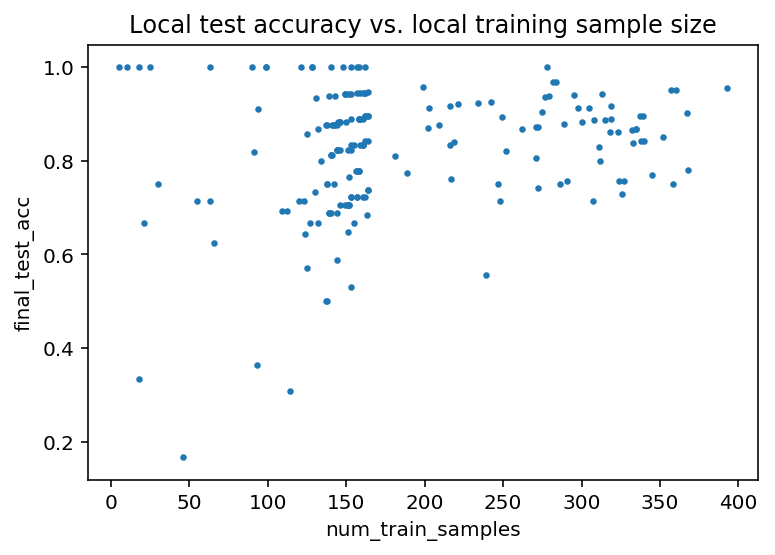

In [20]:
config_num = 0
pd.concat([hyper_df.loc[config_num].tail(1).reset_index(drop=True).T[0].rename('final_test_acc'), 
           samples_per_writer], axis=1).plot.scatter(x='num_train_samples', y='final_test_acc', s=5)
plt.title('Local test accuracy vs. local training sample size');

In [21]:
hyper_df.pipe(inner_transpose).groupby(level=6).mean()[40]

description
Both latents           0.861860
No latent              0.815424
One latent             0.854733
bias latent            0.819221
both latents                NaN
exp 1750: no latent         NaN
one latents                 NaN
Name: 40, dtype: float64

In [33]:
config_num = 0
display(config_df.loc[config_num].to_frame().T)
with open(os.path.join('../experiments/femnist', directories[config_num], 'model_weights.pickle'), 'rb') as f:
    model_weights=pickle.load(f)

,batch_size,both,data_size,dataset,date,description,eval_every,latent_config,latent_space,lr,model_size,num_epochs,print_freq,seed,testing,variational,z_dim
0,1000,False,small,femnist,08-04 21-23-46,bias latent,3,none,True,0.01,small,40,5,24,False,True,"[4, 16]"


In [35]:
[x.shape for x in model_weights]

[(3, 3, 1, 16), (16,), (3, 3, 16, 32), (32,), (1568, 62), (190, 62), (190, 62)]

In [36]:
%load_ext autoreload
%autoreload 2
sys.path.insert(1, '/Users/milesturpin/Dev/latent_variable_nn')
sys.path.insert(1, '/Users/milesturpin/Dev/models')
from models.cnn import LatentBiasCNN
import argparse

args = argparse.Namespace()
args_dict = vars(args)
args_dict.update(hyperparams[config_num])
args_dict['latent_config'] = 'blubl'

opt = tf.keras.optimizers.Adam(1e-3)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
latent3000 = LatentBiasCNN(
    opt, loss_fn, [len(np.unique(gid_train))], 
    args, experiment_dir=None, logger=None)
latent3000(x_train[:2], gid_train[:2].astype(np.int32))
print([x.shape for x in latent3000.get_weights()])
latent3000.set_weights(model_weights);

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[(3, 3, 1, 16), (16,), (3, 3, 16, 32), (32,), (1568, 256), (256,), (256, 62), (190, 62), (190, 62)]


ValueError: You called `set_weights(weights)` on layer "latent_bias_cnn_6" with a  weight list of length 7, but the layer was expecting 9 weights. Provided weights: [array([[[[-0.18667716, -0.11146889, -0.44565418, ...

# old way

In [599]:
directories = ['sota/femnist/2019-07-22_05-33-52_lr_0.001_batch-size_200_num-epochs_10_data-size_large_model-size_large_z-dim_20_latent_True_concatdense_True_variational_True_seed_None_/',
 'sota/femnist/2019-07-22_05-35-57_lr_0.0001_batch-size_200_num-epochs_10_data-size_large_model-size_large_z-dim_20_latent_True_concatdense_True_variational_True_seed_None_/',
 'sota/femnist/2019-07-22_05-37-29_lr_0.001_batch-size_200_num-epochs_10_data-size_large_model-size_large_z-dim_20_latent_False_concatdense_True_variational_True_seed_None_/',
 'sota/femnist/2019-07-22_05-38-48_lr_0.001_batch-size_200_num-epochs_20_data-size_large_model-size_large_z-dim_10_latent_True_concatdense_True_variational_True_seed_None_/']

In [600]:
json_dicts = []
for exp_dir  in directories:
    with open(os.path.join('../experiments', exp_dir, 'training_stats.json'), 'r') as f:
        json_dicts.append(json.load(f))

In [601]:
# Extract hyper param settings from dir names
#hyperparams = ['lr', 'batch_size',  'model_size', 
# 'latent_vars', 'concat_dense', 'seed']
hyperparams = ['lr', 'batch_size', 'num_epochs', 'data_size', 'model_size', 'z_dim', 
               'latent_vars', 'concatdense','variational', 'seed']
get_hyper = lambda i: [exp_dir.split('_')[2:-1][i] for exp_dir in directories]
hyper_dict = {
    hyper: get_hyper(1+2*i) 
    for i, hyper 
    in enumerate(hyperparams)
}
# hyper_dict = {
#     'lr': get_hyper(1),
#     'batch_size': get_hyper(3),
#     'num_epochs': get_hyper(5),
#     'model_size': get_hyper(5),
#     'z_dim': get_hyper(9),
#     'latent_vars': get_hyper(7),
#     'concat_dense': get_hyper(9),
#     'variational': get_hyper(9)
#     'seed': get_hyper(11),
# }

config_df = pd.DataFrame(hyper_dict)

config_df

,lr,batch_size,num_epochs,data_size,model_size,z_dim,latent_vars,concatdense,variational,seed
0,0.001,200,10,large,large,20,True,True,True,None
1,0.0001,200,10,large,large,20,True,True,True,None
2,0.001,200,10,large,large,20,False,True,True,None
3,0.001,200,20,large,large,10,True,True,True,None


,lr,batch_size,num_epochs,data_size,model_size,z_dim,latent_vars,concatdense,variational,seed
0,0.001,200,10,large,large,20,True,True,True,None
1,0.0001,200,10,large,large,20,True,True,True,None
2,0.001,200,10,large,large,20,False,True,True,None
3,0.001,200,20,large,large,10,True,True,True,None


Taking 50 percentile bc didnt want to deal with nans
Weighted test accuracy: 0.902, 10th percentile: 0.786, 90th percentile: 1.0
Taking 50 percentile bc didnt want to deal with nans
Weighted test accuracy: 0.889, 10th percentile: 0.75, 90th percentile: 0.972
Taking 50 percentile bc didnt want to deal with nans
Weighted test accuracy: 0.875, 10th percentile: 0.733, 90th percentile: 0.962
Taking 50 percentile bc didnt want to deal with nans
Weighted test accuracy: 0.895, 10th percentile: 0.778, 90th percentile: 1.0


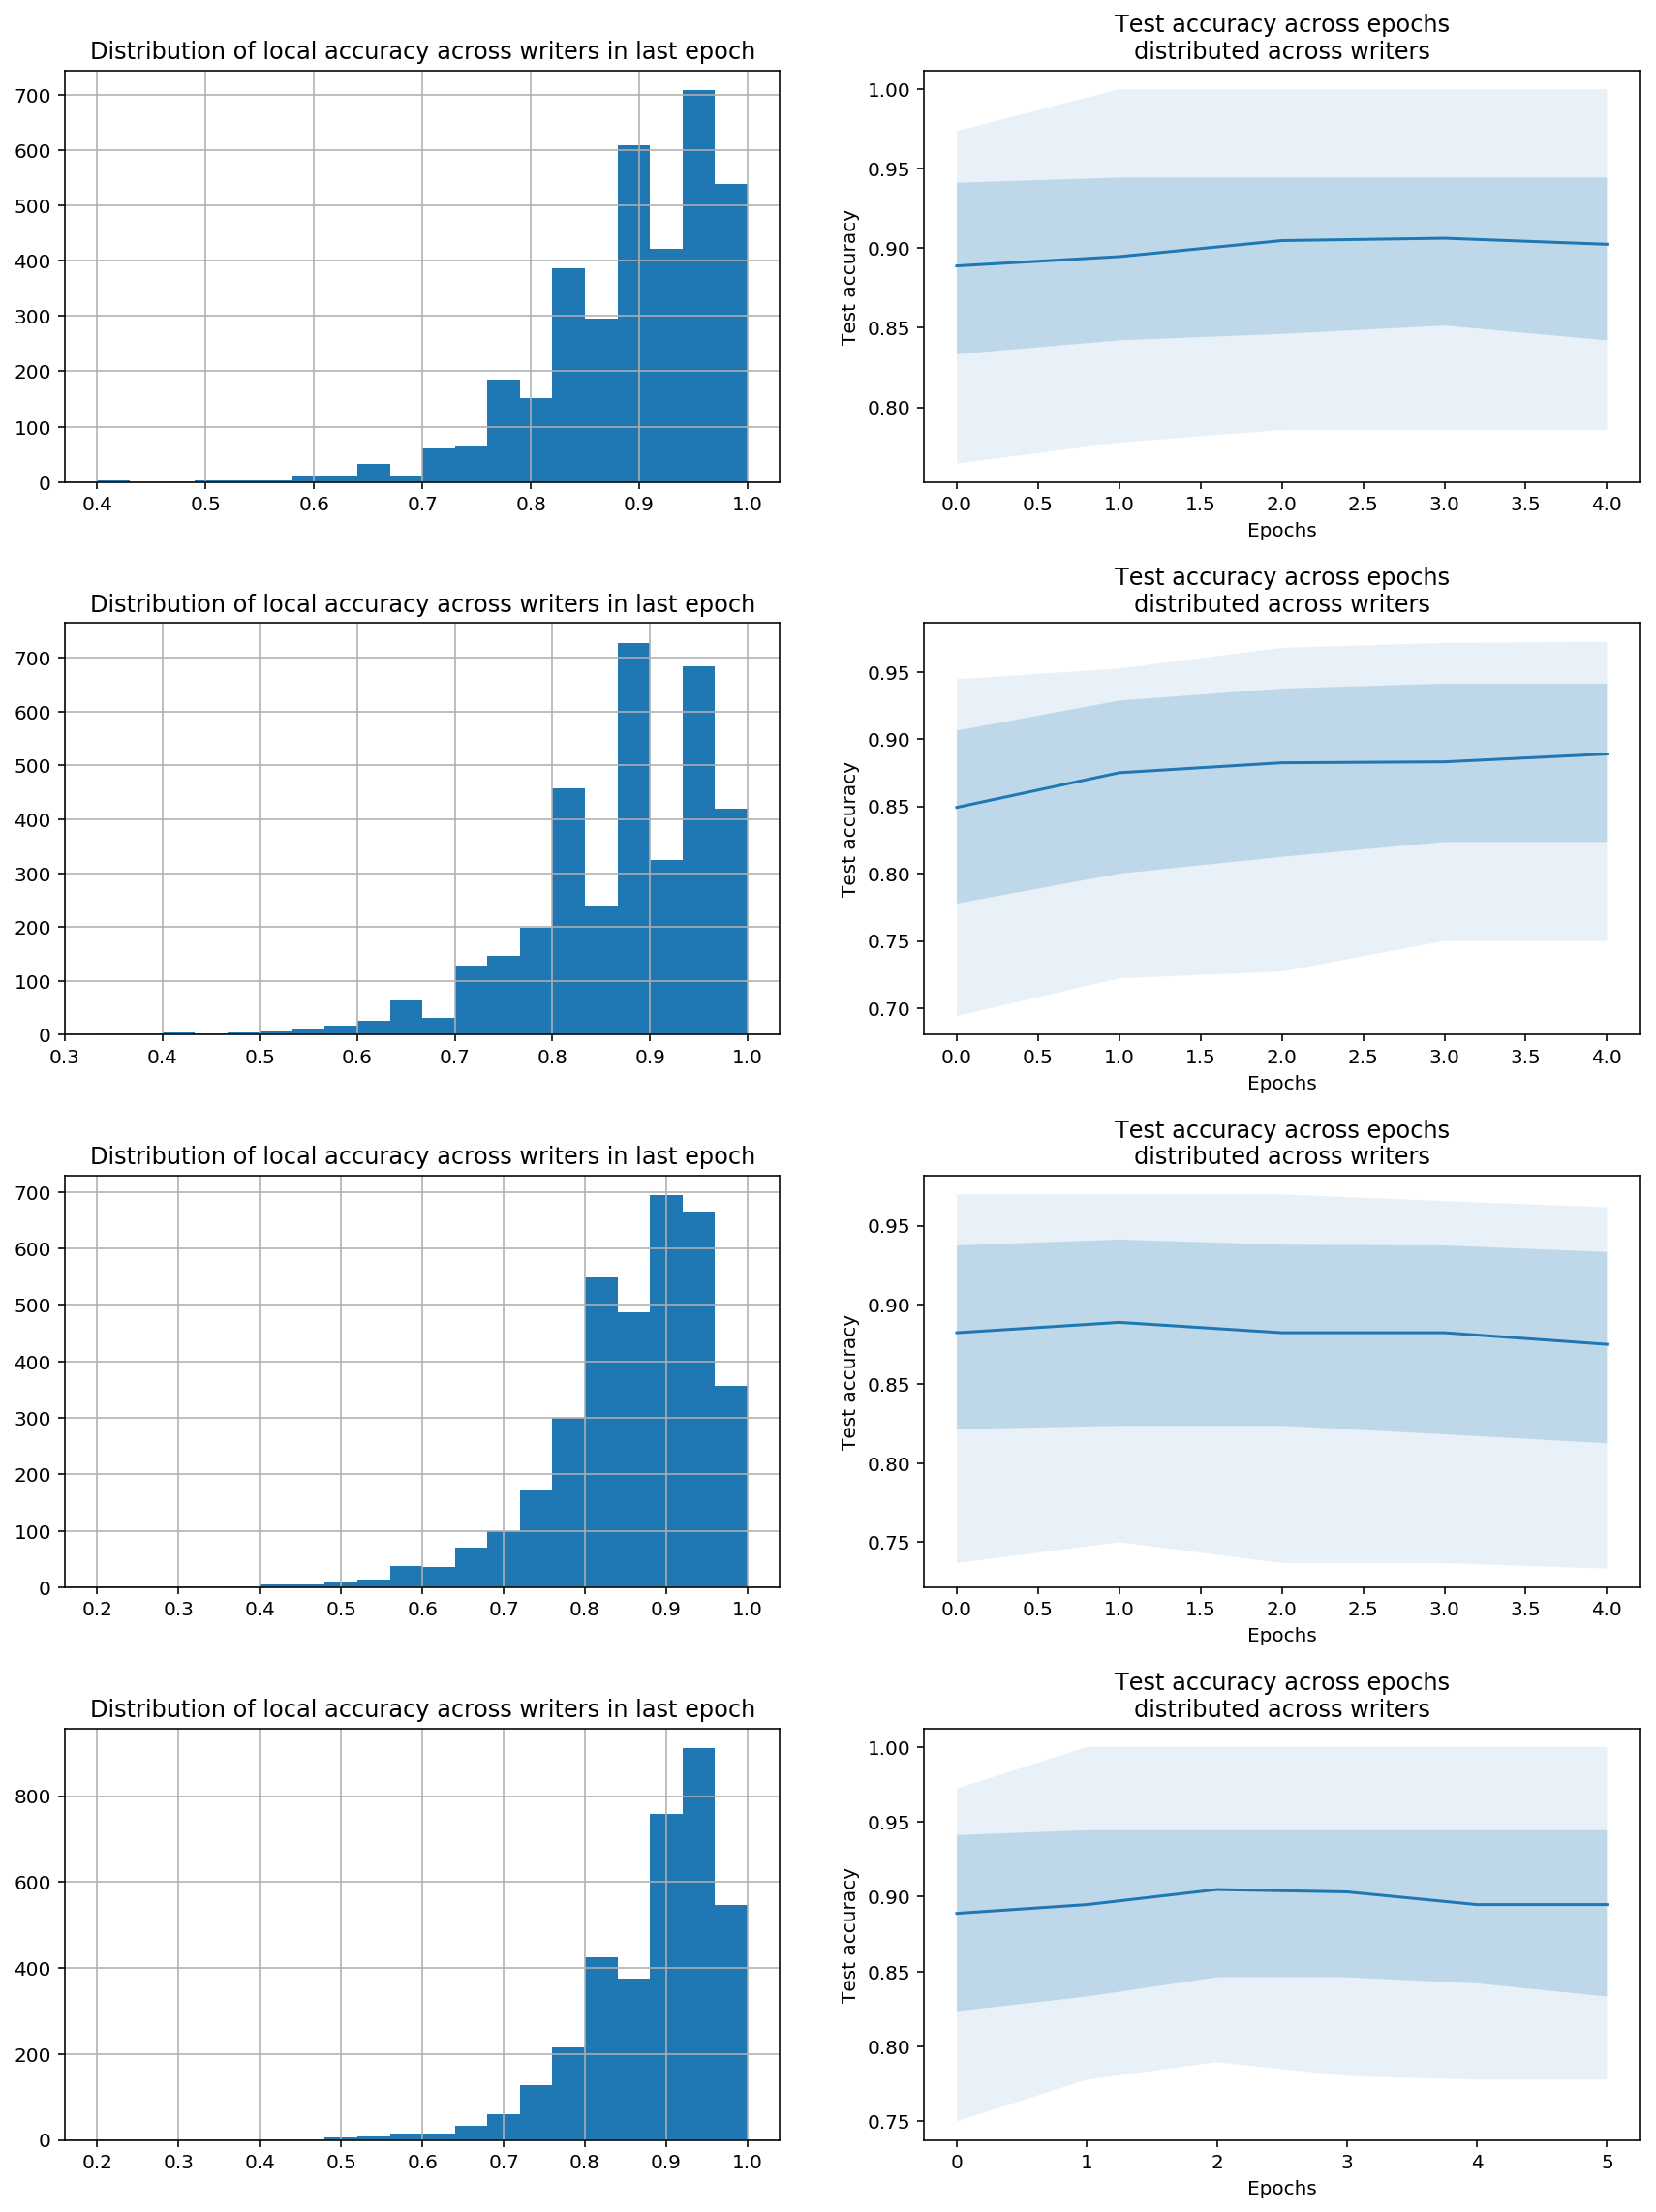

In [602]:
num_configs = len(directories)
plt.figure(figsize=(12,num_configs*4))

display(config_df)

hyper_df = config_df.copy()

config_df_list = []

for i in range(num_configs):
    train_stats = json_dicts[i]

    flat_dict = {
        (int(gid),int(epoch)): train_stats[epoch][gid]['test_acc'] 
        for j, epoch in enumerate(train_stats)
        for gid in train_stats[epoch]
        if type(train_stats[epoch][gid])==dict}

    fed_acc_df = pd.DataFrame.from_dict(flat_dict, orient='index', columns=['test_acc'])
    fed_acc_df = fed_acc_df.dropna()
    
    fed_acc_df.index = pd.MultiIndex.from_tuples(fed_acc_df.index)
    fed_acc_df = fed_acc_df.unstack().sort_index()['test_acc'].T

    config_df_list.append(fed_acc_df)
    
    plt.subplot(num_configs,2,2*i+1)
    fed_acc_df.tail(1).squeeze().hist(bins=20)
    plt.title('Distribution of local accuracy across writers in last epoch');

    print('Taking 50 percentile bc didnt want to deal with nans')
    stats = [
        #round(np.dot(fed_acc_df.tail(1).squeeze().values, samples_weights.values),3),  
        round(np.percentile(sorted(fed_acc_df.tail(1).squeeze().dropna().values), 50),3),
        round(np.percentile(sorted(fed_acc_df.tail(1).squeeze().dropna().values), 10),3),
        round(np.percentile(sorted(fed_acc_df.tail(1).squeeze().dropna().values), 90),3)]
    print('Weighted test accuracy: {}, 10th percentile: {}, 90th percentile: {}'.format(*stats))

    plt.subplot(num_configs,2,2*i+2)
    #plt.plot(fed_dict['global_accuracy_per_round'], c='C0')
    plt.plot(fed_acc_df.apply(lambda s: np.percentile(s.dropna(), 50), axis=1).values)
    # plt.plot(fed_acc_df.apply(lambda s: np.percentile(s, 10), axis=1).values)
    plt.fill_between(range(len(fed_acc_df)), 
                     fed_acc_df.apply(lambda s: np.percentile(s.dropna(), 90), axis=1).values,
                     fed_acc_df.apply(lambda s: np.percentile(s.dropna(), 10), axis=1).values,
                     alpha=0.1, facecolor='C0')

    plt.fill_between(range(len(fed_acc_df)), 
                     fed_acc_df.apply(lambda s: np.percentile(s.dropna(), 75), axis=1).values,
                     fed_acc_df.apply(lambda s: np.percentile(s.dropna(), 25), axis=1).values,
                     alpha=0.2, facecolor='C0')

    plt.title('Test accuracy across epochs\n'
              'distributed across writers')
    plt.xlabel('Epochs')
    plt.ylabel('Test accuracy')

plt.tight_layout();

In [603]:
config_df

,lr,batch_size,num_epochs,data_size,model_size,z_dim,latent_vars,concatdense,variational,seed
0,0.001,200,10,large,large,20,True,True,True,None
1,0.0001,200,10,large,large,20,True,True,True,None
2,0.001,200,10,large,large,20,False,True,True,None
3,0.001,200,20,large,large,10,True,True,True,None


In [606]:
def inner_transpose(df):
    return df.stack().swaplevel(i=-2, j=-1).unstack()

hyper_df = (
    config_df
    .rename_axis(index='config')
    .reset_index()
    .groupby(['config'] + hyperparams)
    # query the results dataframe from config_df_list
    # dropping the index so all the evaluated epochs line up 
    # TODO: maybe change this
    .apply(lambda df: config_df_list[df['config'].values[0]].reset_index(drop=True))
    .pipe(inner_transpose)
)

In [607]:
inner_transpose(hyper_df).loc[0]

0     \
lr    batch_size num_epochs data_size model_size z_dim latent_vars concatdense variational seed               
0.001 200        10         large     large      20    True        True        True        None 0  0.871795   
                                                                                                1  0.871795   
                                                                                                2  0.923077   
                                                                                                3  0.923077   
                                                                                                4  0.897436   

                                                                                                       1     \
lr    batch_size num_epochs data_size model_size z_dim latent_vars concatdense variational seed               
0.001 200        10         large     large      20    True        True        True        None 0  0.904762   
                                                                                                1  0.928571   
                                                                                                2  0.904762   
                                                                                                3  0.904762   
                                                                                                4  0.952381   

                                                                                                      2     \
lr    batch_size num_epochs data_size model_size z_dim latent_vars concatdense variational seed              
0.001 200        10         large     large      20    True        True        True        None 0  0.97561   
                                                                                                1  0.95122   
                                                                                                2  0.97561   
                                                                                                3  0.95122   
                                                                                                4  0.95122   

                                                                                                    3     \
lr    batch_size num_epochs data_size model_size z_dim latent_vars concatdense variational seed            
0.001 200        10         large     large      20    True        True        True        None 0  0.850   
                                                                                                1  0.875   
                                                                                                2  0.875   
                                                                                                3  0.850   
                                                                                                4  0.875   

                                                                                                      4     \
lr    batch_size num_epochs data_size model_size z_dim latent_vars concatdense variational seed              
0.001 200        10         large     large      20    True        True        True        None 0  1.00000   
                                                                                                1  0.93750   
                                                                                                2  0.93750   
                                                                                                3  0.90625   
                                                                                                4  0.96875   

                                                                                                       5     \
lr    batch_size num_epochs data_size model_size z_dim latent_vars concatdense variational seed               
0.001 200        10       

In [608]:
hyper_df.loc[0].head()

0  \
lr    batch_size num_epochs data_size model_size z_dim latent_vars concatdense variational seed               
0.001 200        10         large     large      20    True        True        True        None 0  0.871795   
                                                                                                1  0.904762   
                                                                                                2  0.975610   
                                                                                                3  0.850000   
                                                                                                4  1.000000   

                                                                                                          1  \
lr    batch_size num_epochs data_size model_size z_dim latent_vars concatdense variational seed               
0.001 200        10         large     large      20    True        True        True        None 0  0.871795   
                                                                                                1  0.928571   
                                                                                                2  0.951220   
                                                                                                3  0.875000   
                                                                                                4  0.937500   

                                                                                                          2  \
lr    batch_size num_epochs data_size model_size z_dim latent_vars concatdense variational seed               
0.001 200        10         large     large      20    True        True        True        None 0  0.923077   
                                                                                                1  0.904762   
                                                                                                2  0.975610   
                                                                                                3  0.875000   
                                                                                                4  0.937500   

                                                                                                          3  \
lr    batch_size num_epochs data_size model_size z_dim latent_vars concatdense variational seed               
0.001 200        10         large     large      20    True        True        True        None 0  0.923077   
                                                                                                1  0.904762   
                                                                                                2  0.951220   
                                                                                                3  0.850000   
                                                                                                4  0.906250   

                                                                                                          4  \
lr    batch_size num_epochs data_size model_size z_dim latent_vars concatdense variational seed               
0.001 200        10         large     large      20    True        True        True        None 0  0.897436   
                                                                                                1  0.952381   
                                                                                                2  0.951220   
                                                                                                3  0.875000   
                                                                                                4  0.968750   

                                                                                                    5  
lr    batch_size num_epochs data_size model_size z_dim latent_vars concatdense variational seed        
0.001 20

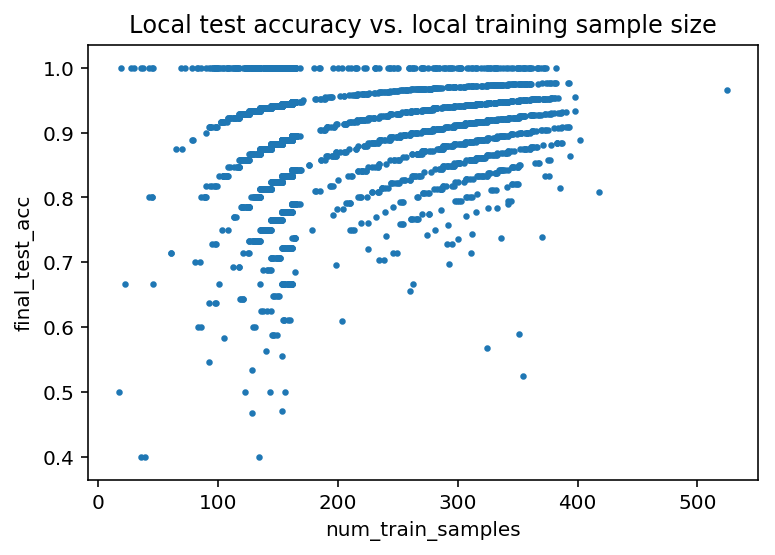

In [609]:
config_num = 0
pd.concat([hyper_df.loc[config_num][4].reset_index(drop=True).rename('final_test_acc'), 
           samples_per_writer], axis=1).plot.scatter(x='num_train_samples', y='final_test_acc', s=5)
plt.title('Local test accuracy vs. local training sample size');

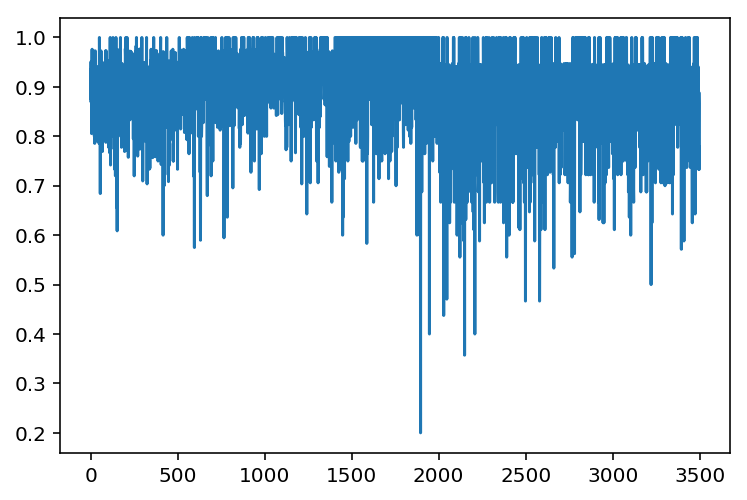

In [616]:
plt.plot(hyper_df.loc[0][1].reset_index(drop=True))

In [618]:
config_num = 0

with open(os.path.join('../experiments', directories[config_num], 'model_weights.pickle'), 'rb') as f:
    model_weights=pickle.load(f)

In [619]:
import argparse
args = argparse.Namespace()
args.lr=float(config_df['lr'].loc[config_num])
args.batch_size=int(config_df['batch_size'].loc[config_num])
args.num_epochs=int(config_df['num_epochs'].loc[config_num])
args.model_size=config_df['model_size'].loc[config_num]
args.z_dim=[int(config_df['z_dim'].loc[config_num])]
args.eval_every=1
args.seed=None
args.tag=''
args.testing=False
args.latent_space=bool(config_df['latent_vars'].loc[config_num])
args.concat_dense=bool(config_df['concatdense'].loc[config_num])
args.variational=bool(config_df['variational'].loc[config_num])

In [620]:
%load_ext autoreload
%autoreload 2
from models import LatentCNN

opt = tf.keras.optimizers.Adam(1e-3)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
latent3000 = LatentCNN(opt, loss_fn, [len(np.unique(gid_train))], args,
                              experiment_dir=None, logger=None)
latent3000(x_train[:2], gid_train[:2])
latent3000.set_weights(model_weights);

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [630]:
preds = latent3000(x_train[:1000], gid_train[:1000])

In [625]:
from sklearn.metrics import accuracy_score

In [631]:
tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_train[:1000], preds))

<tf.Tensor: id=27437, shape=(), dtype=float32, numpy=0.24123117>

In [632]:
accuracy_score(y_train[:1000], preds.numpy().argmax(axis=1))

0.924

In [652]:
preds = latent3000(x_test[:10000], gid_test[:10000])

In [634]:
from sklearn.metrics import accuracy_score

In [654]:
tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_test[:10000], preds))

<tf.Tensor: id=27814, shape=(), dtype=float32, numpy=0.36271435>

In [653]:
accuracy_score(y_test[:10000], preds.numpy().argmax(axis=1))

0.8822

# end old way

In [361]:
latent3000.summary()

Model: "latent_cnn_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_8 (Reshape)          multiple                  0         
_________________________________________________________________
conv2d_16 (Conv2D)           multiple                  160       
_________________________________________________________________
max_pooling2d_16 (MaxPooling multiple                  0         
_________________________________________________________________
conv2d_17 (Conv2D)           multiple                  4640      
_________________________________________________________________
max_pooling2d_17 (MaxPooling multiple                  0         
_________________________________________________________________
flatten_8 (Flatten)          multiple                  0         
_________________________________________________________________


ValueError: You tried to call `count_params` on dense_16, but the layer isn't built. You can build it manually via: `dense_16.build(batch_input_shape)`.

In [277]:
[x.shape for x in model_weights]

[(3, 3, 1, 16),
 (16,),
 (3, 3, 16, 32),
 (32,),
 (1584, 256),
 (256,),
 (272, 62),
 (62,),
 (190, 16),
 (190, 16),
 (190, 16),
 (190, 16)]

In [362]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_mu = pca.fit_transform(latent3000.z_mu.numpy())
pca = PCA(n_components=2)
pca_sigma = pca.fit_transform(latent3000.z_sigma.numpy())

In [279]:
from sklearn.decomposition import PCA
pca2 = PCA(n_components=2)
pca_mu2 = pca.fit_transform(latent3000.z2_mu.numpy())
pca2 = PCA(n_components=2)
pca_sigma2 = pca.fit_transform(latent3000.z2_sigma.numpy())

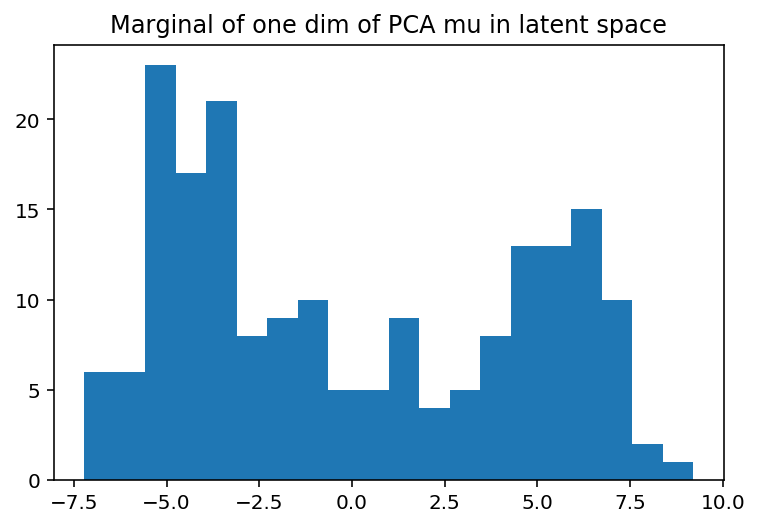

In [363]:
plt.hist(pca_mu[:,0], bins=20)
plt.title('Marginal of one dim of PCA mu in latent space');

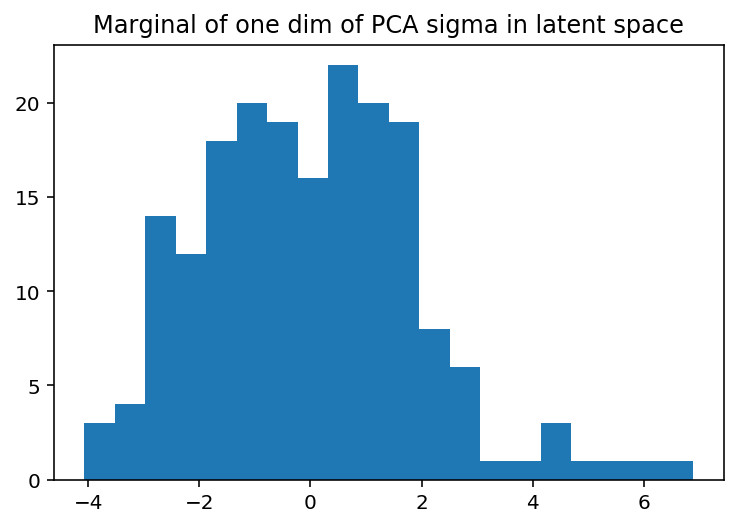

In [364]:
plt.hist(pca_sigma[:,0], bins=20)
plt.title('Marginal of one dim of PCA sigma in latent space');

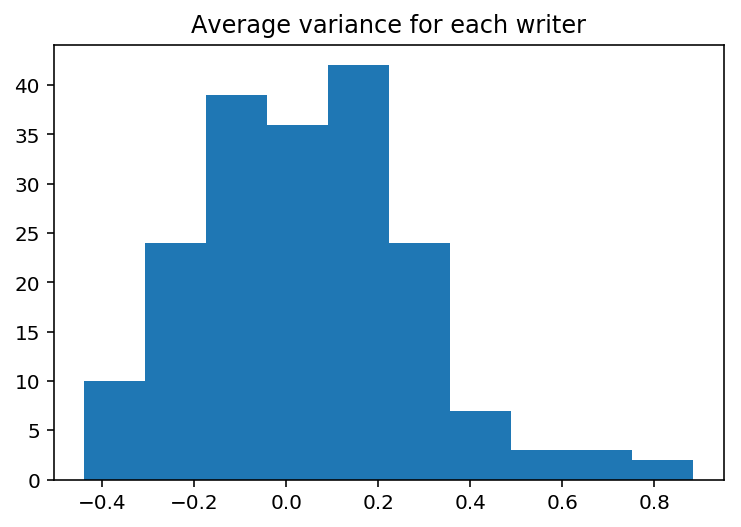

In [365]:
plt.hist(latent3000.z_sigma.numpy().mean(axis=1))
plt.title('Average variance for each writer');

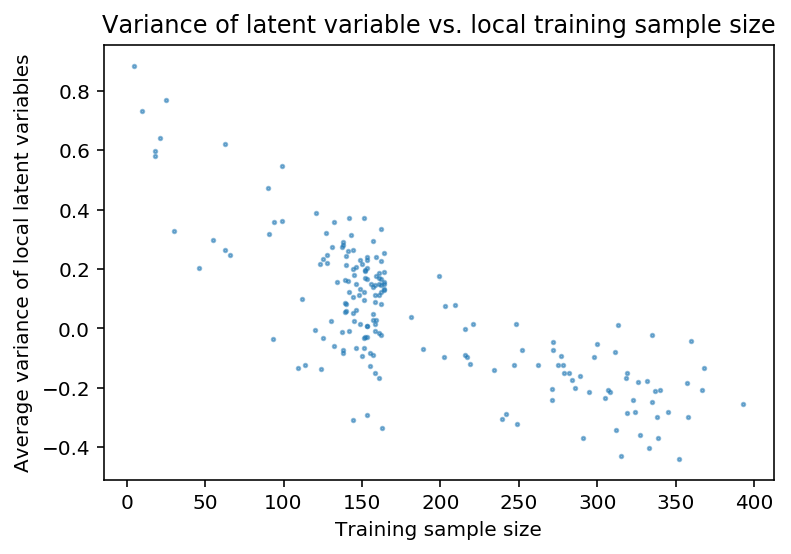

In [366]:
plt.scatter(samples_per_writer.values, 
            latent3000.z_sigma.numpy().mean(axis=1),
            s=3, alpha=0.5
            )
plt.xlabel('Training sample size')
plt.ylabel('Average variance of local latent variables')
plt.title('Variance of latent variable vs. local training sample size');

### latent var 1

In [367]:
from sklearn.mixture import GaussianMixture

mix = GaussianMixture(n_components=2, covariance_type='full')
mix.fit(latent3000.z_mu.numpy())

mix_dist = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=mix.weights_),
    #components_distribution=tfd.MultivariateNormalDiag(
    #    loc=mix.means_, scale_identity_multiplier=mix.covariances_)
    #components_distribution=tfd.MultivariateNormalDiag(
    #    loc=mix.means_, scale_diag=mix.covariances_)
    components_distribution=tfd.MultivariateNormalFullCovariance(
loc=mix.means_, covariance_matrix=mix.covariances_));

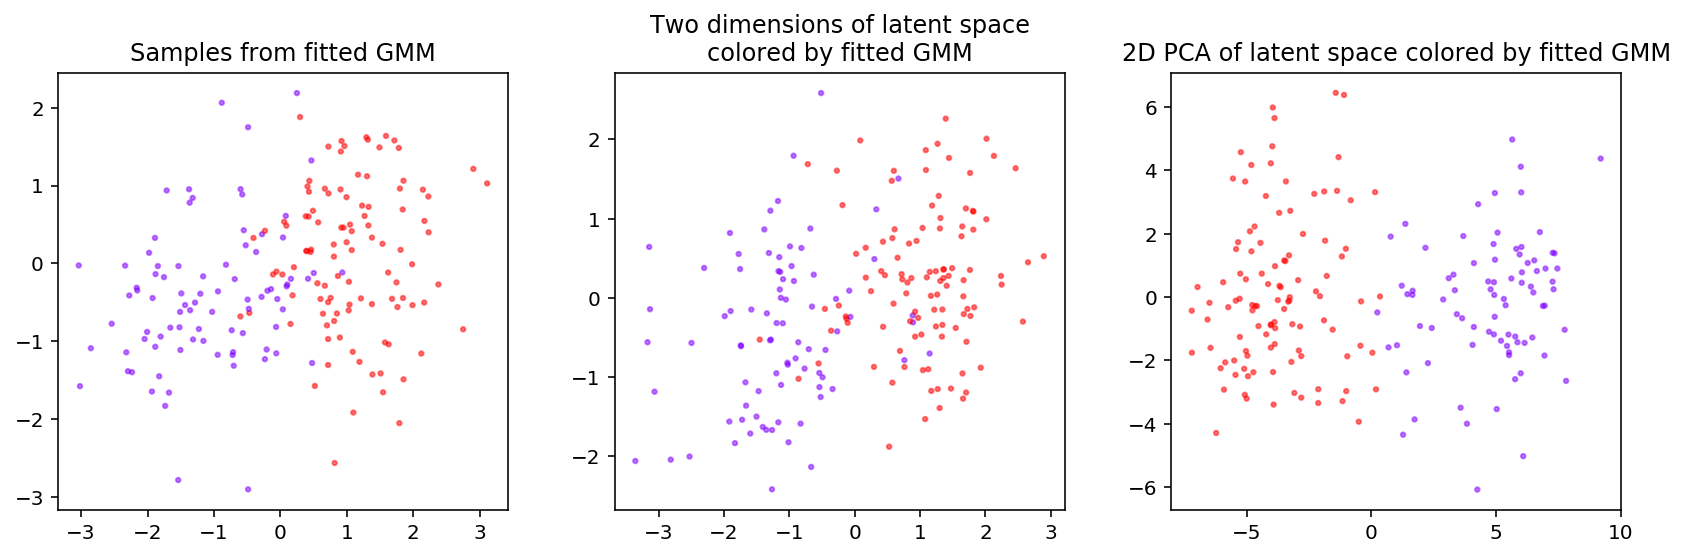

In [368]:
plt.figure(figsize=(12,4))
plt.subplot(131)

mix_samp = mix_dist.sample(190)
assign_samp = tfd.Categorical(probs=mix.predict_proba(mix_samp)).sample().numpy()

plt.scatter(mix_samp[:,1], mix_samp[:,2], s=5, 
           c=assign_samp, cmap='rainbow', alpha=0.5)
plt.title('Samples from fitted GMM')

plt.subplot(132)
z_space = latent3000.z_mu.numpy()
assign_samp = tfd.Categorical(probs=mix.predict_proba(z_space)).sample().numpy()
plt.scatter(z_space[:,1], z_space[:,2], s=5, 
           c=assign_samp, cmap='rainbow', alpha=0.5)
plt.title('Two dimensions of latent space\ncolored by fitted GMM')

plt.subplot(133)
z_space = pca_mu
plt.scatter(z_space[:,0], z_space[:,1], s=5, 
           c=assign_samp, cmap='rainbow', alpha=0.5)
plt.title('2D PCA of latent space colored by fitted GMM')
plt.tight_layout();

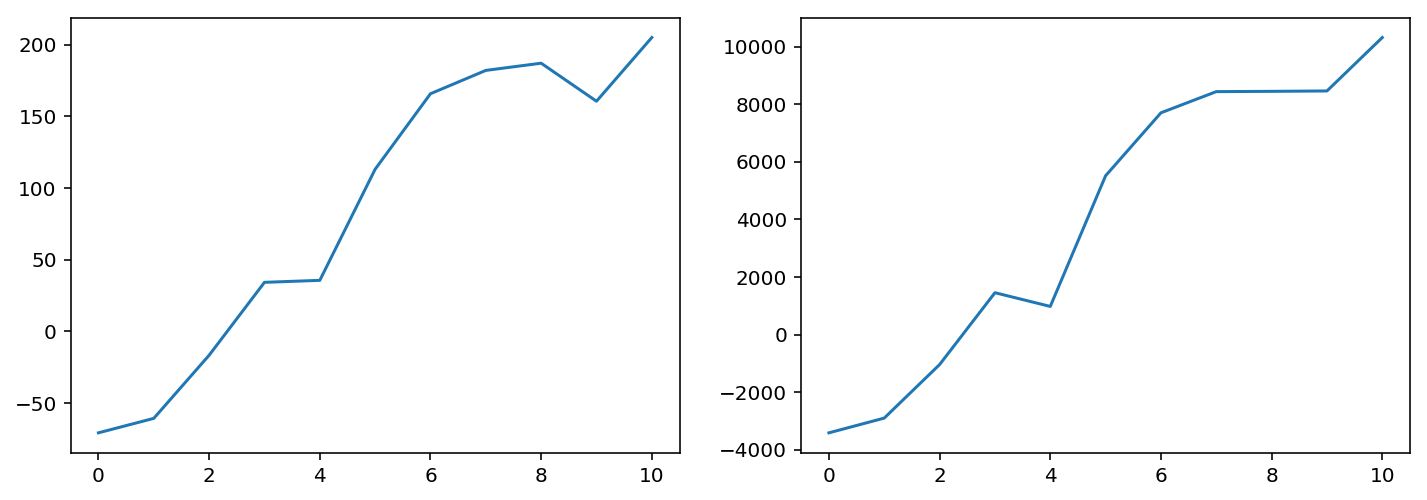

In [369]:
lst = []
aics=[]
bics=[]
logprobs =[ ]
from sklearn.model_selection import train_test_split
train, test = train_test_split(latent3000.z_mu.numpy())
for i in range(1,12):
    mix = GaussianMixture(n_components=i)
    mix.fit(latent3000.z_mu.numpy())
    
    
    mix_dist = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=mix.weights_),
    #components_distribution=tfd.MultivariateNormalDiag(
    #    loc=mix.means_, scale_identity_multiplier=mix.covariances_)
    #components_distribution=tfd.MultivariateNormalDiag(
    #    loc=mix.means_, scale_diag=mix.covariances_)
    components_distribution=tfd.MultivariateNormalFullCovariance(
        loc=mix.means_, covariance_matrix=mix.covariances_))
    
    
    lst.append(mix.lower_bound_)
    aics.append(mix.aic(test))
    bics.append(mix.bic(test))
    logprobs.append(tf.reduce_sum(mix_dist.log_prob(test)))
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(lst)
plt.subplot(122)
plt.plot(logprobs);

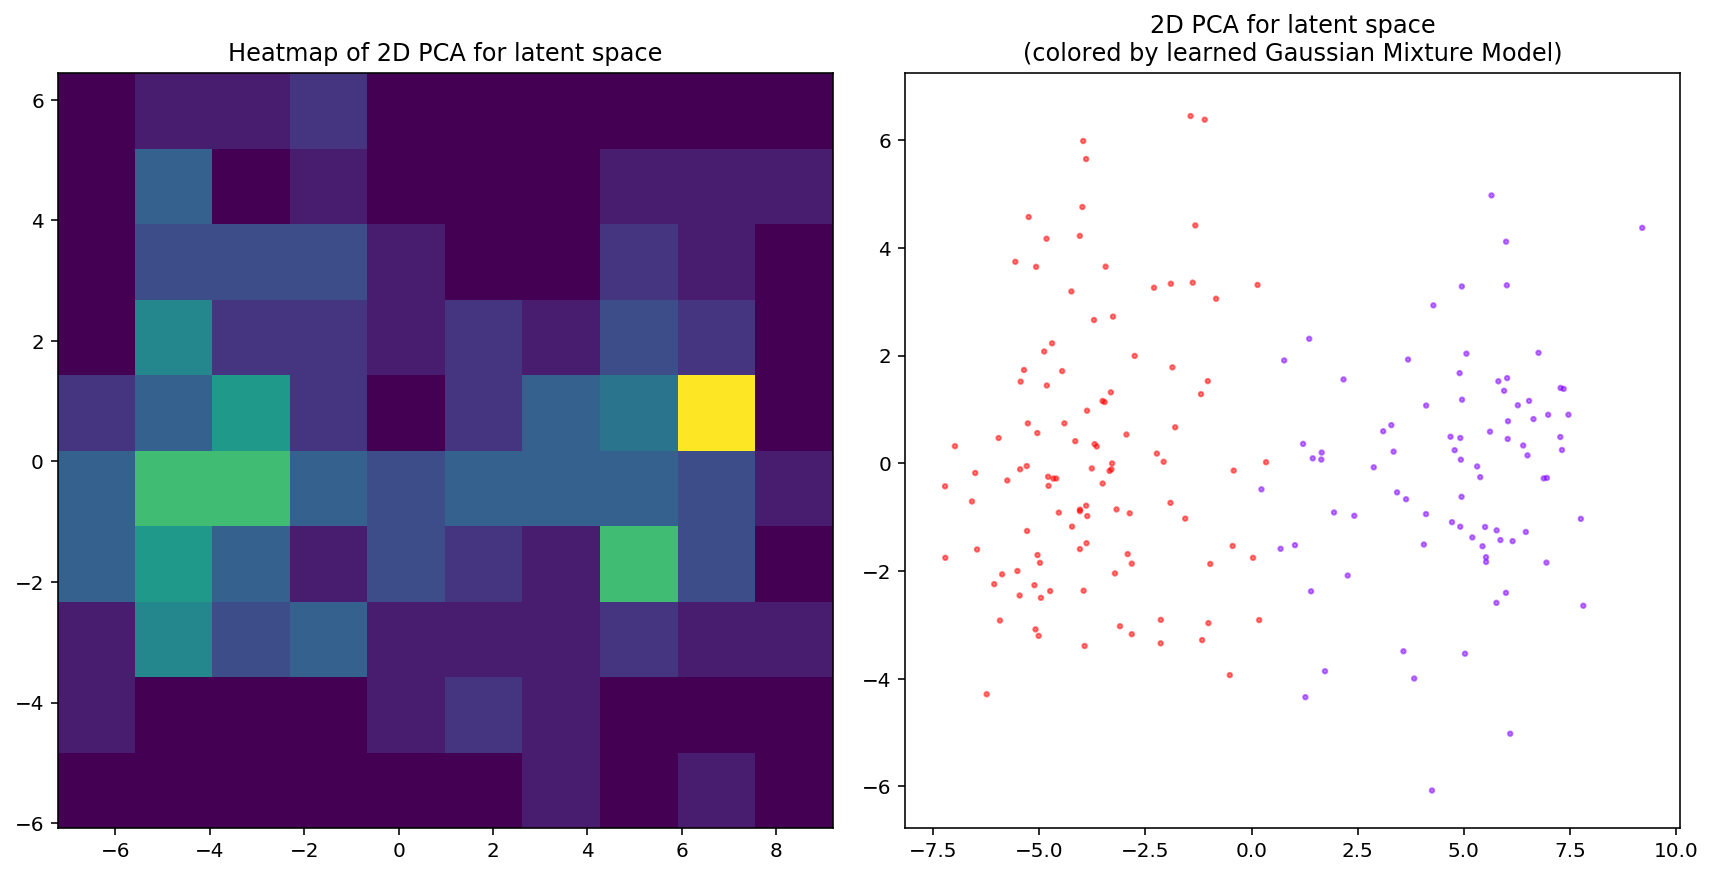

In [370]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.hist2d(pca_mu[:,0], pca_mu[:,1], bins=10)
plt.title('Heatmap of 2D PCA for latent space')

plt.subplot(122)
plt.scatter(pca_mu[:,0], pca_mu[:,1],
            c=assign_samp, 
            cmap='rainbow', s=5, alpha=0.5)

plt.scatter(pca_mu[:,0], pca_mu[:,1],
            c=assign_samp, 
            cmap='rainbow', 
            s=1000*np.square(np.mean(latent3000.z_sigma.numpy(),axis=1)), alpha=0.0001,)

plt.tight_layout()
plt.title('2D PCA for latent space\n(colored by learned Gaussian Mixture Model)');

### Factor loadings of latent space 1

In [371]:
mean_latent_vector = (
    pd.concat(
    [pd.DataFrame({'cluster':assign_samp}),
    pd.DataFrame(latent3000.z_mu.numpy())], 
    axis=1)
    .groupby('cluster')
    .mean())

In [375]:
mean_latent_vector

,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,60,61
cluster,,,,,,,,,,,,,,,,,,,,,
0,-1.289018,-1.149797,-0.427905,-0.357637,-0.658066,-1.040100,-0.483686,-0.427470,-0.689846,-0.593832,...,-0.191848,-0.036181,-1.012399,0.209312,-0.916181,-0.746958,-0.449425,-0.429770,-0.646616,-0.449754
1,1.089516,1.050361,0.215790,0.200317,0.360105,0.665065,0.333303,0.338626,0.362602,0.530925,...,-0.999894,-0.395746,0.057651,-0.972103,0.118338,0.108440,-0.073299,-0.112932,-0.327390,-0.154820


In [372]:
[x.shape for x in latent3000.get_weights()]

[(3, 3, 1, 16), (16,), (3, 3, 16, 32), (32,), (1568, 62), (190, 62), (190, 62)]

In [373]:
mean_latent_vector.shape

(2, 62)

In [374]:
#latent3000.get_weights()[-6][-16:].shape

In [376]:
latent3000.get_weights()[-2].shape

(190, 62)

In [378]:
cluster_y_dist = tf.nn.softmax(
    (mean_latent_vector
    @ latent3000.get_weights()[-6][-16:]).values, 
    axis=1)

ValueError: Dot product shape mismatch, (2, 62) vs (190, 62)

In [378]:
cluster_y_dist = tf.nn.softmax(
    (mean_latent_vector
    @ latent3000.get_weights()[-2]).values, 
    axis=1)

ValueError: Dot product shape mismatch, (2, 62) vs (190, 62)

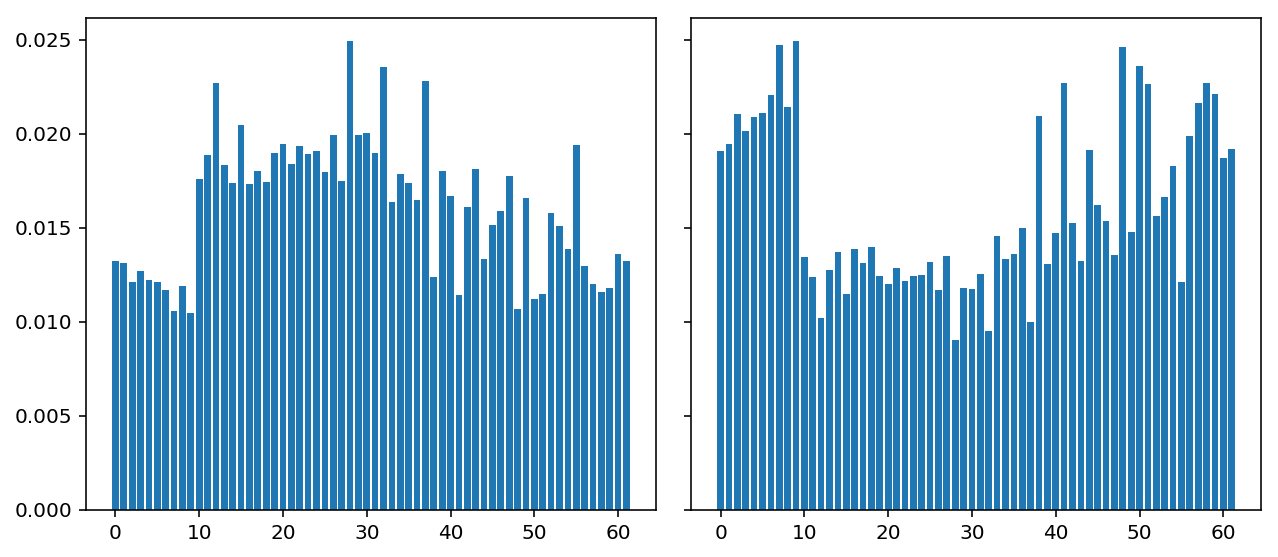

In [295]:
fig, axes = plt.subplots(1,2,figsize=(9,4), sharey=True)
for i in range(2):
    axes[i].bar(range(62),cluster_y_dist[i])
plt.tight_layout();

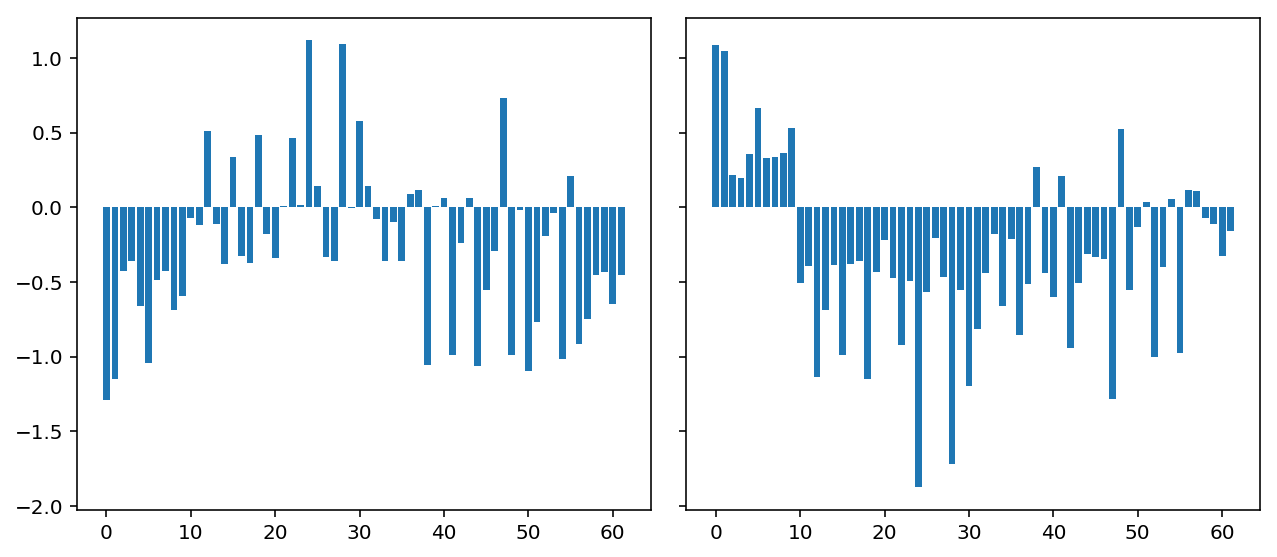

In [379]:
fig, axes = plt.subplots(1,2,figsize=(9,4), sharey=True)
for i in range(2):
    axes[i].bar(range(62),mean_latent_vector.loc[i].values)
plt.tight_layout();

### latent var 2

In [296]:
from sklearn.mixture import GaussianMixture

mix2 = GaussianMixture(n_components=3, covariance_type='full')
mix2.fit(latent3000.z2_mu.numpy())

mix2_dist = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=mix2.weights_),
    #components_distribution=tfd.MultivariateNormalDiag(
    #    loc=mix.means_, scale_identity_multiplier=mix.covariances_)
    #components_distribution=tfd.MultivariateNormalDiag(
    #    loc=mix.means_, scale_diag=mix.covariances_)
    components_distribution=tfd.MultivariateNormalFullCovariance(
loc=mix2.means_, covariance_matrix=mix2.covariances_));

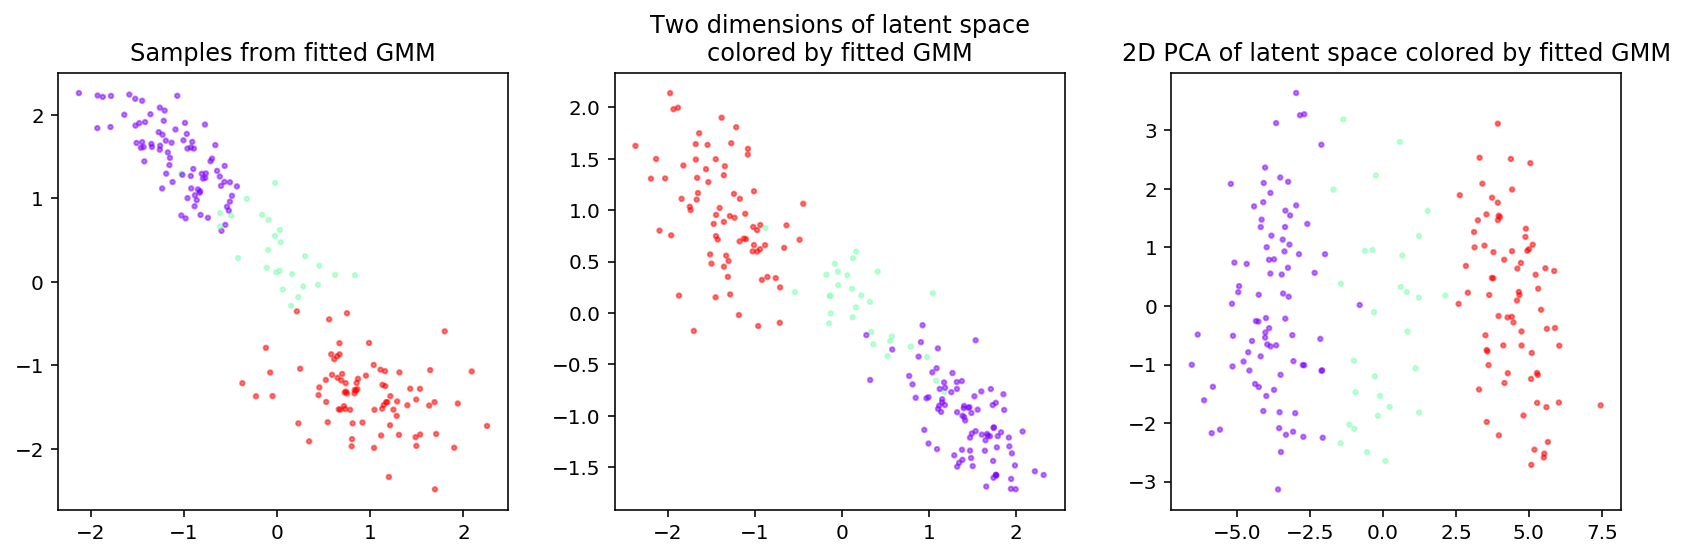

In [297]:
plt.figure(figsize=(12,4))
plt.subplot(131)

mix2_samp = mix2_dist.sample(190)
assign_samp = tfd.Categorical(probs=mix2.predict_proba(mix2_samp)).sample().numpy()
plt.scatter(mix2_samp[:,1], mix2_samp[:,0], s=5, 
           c=assign_samp, cmap='rainbow', alpha=0.5)
plt.title('Samples from fitted GMM')

plt.subplot(132)
z_space = latent3000.z2_mu.numpy()
assign_samp = tfd.Categorical(probs=mix2.predict_proba(z_space)).sample().numpy()
plt.scatter(z_space[:,0], z_space[:,1], s=5, 
           c=assign_samp, cmap='rainbow', alpha=0.5)
plt.title('Two dimensions of latent space\ncolored by fitted GMM')

plt.subplot(133)
z_space = pca_mu2
plt.scatter(z_space[:,0], z_space[:,1], s=5, 
           c=assign_samp, cmap='rainbow', alpha=0.5)
plt.title('2D PCA of latent space colored by fitted GMM')
plt.tight_layout();

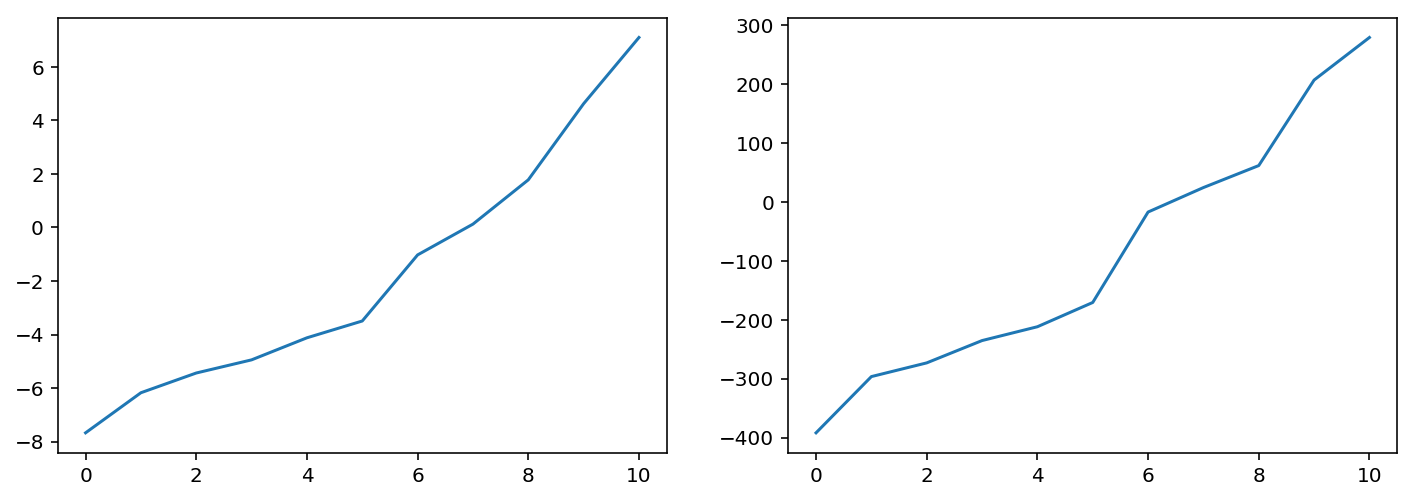

In [298]:
lst = []
aics=[]
bics=[]
logprobs =[ ]
from sklearn.model_selection import train_test_split
train, test = train_test_split(latent3000.z2_mu.numpy())
for i in range(1,12):
    mix2 = GaussianMixture(n_components=i)
    mix2.fit(latent3000.z2_mu.numpy())
    
    
    mix2_dist = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=mix2.weights_),
    #components_distribution=tfd.MultivariateNormalDiag(
    #    loc=mix.means_, scale_identity_multiplier=mix.covariances_)
    #components_distribution=tfd.MultivariateNormalDiag(
    #    loc=mix.means_, scale_diag=mix.covariances_)
    components_distribution=tfd.MultivariateNormalFullCovariance(
        loc=mix2.means_, covariance_matrix=mix2.covariances_))
    
    
    lst.append(mix2.lower_bound_)
    aics.append(mix2.aic(test))
    bics.append(mix2.bic(test))
    logprobs.append(tf.reduce_sum(mix2_dist.log_prob(test)))
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(lst)
plt.subplot(122)
plt.plot(logprobs);

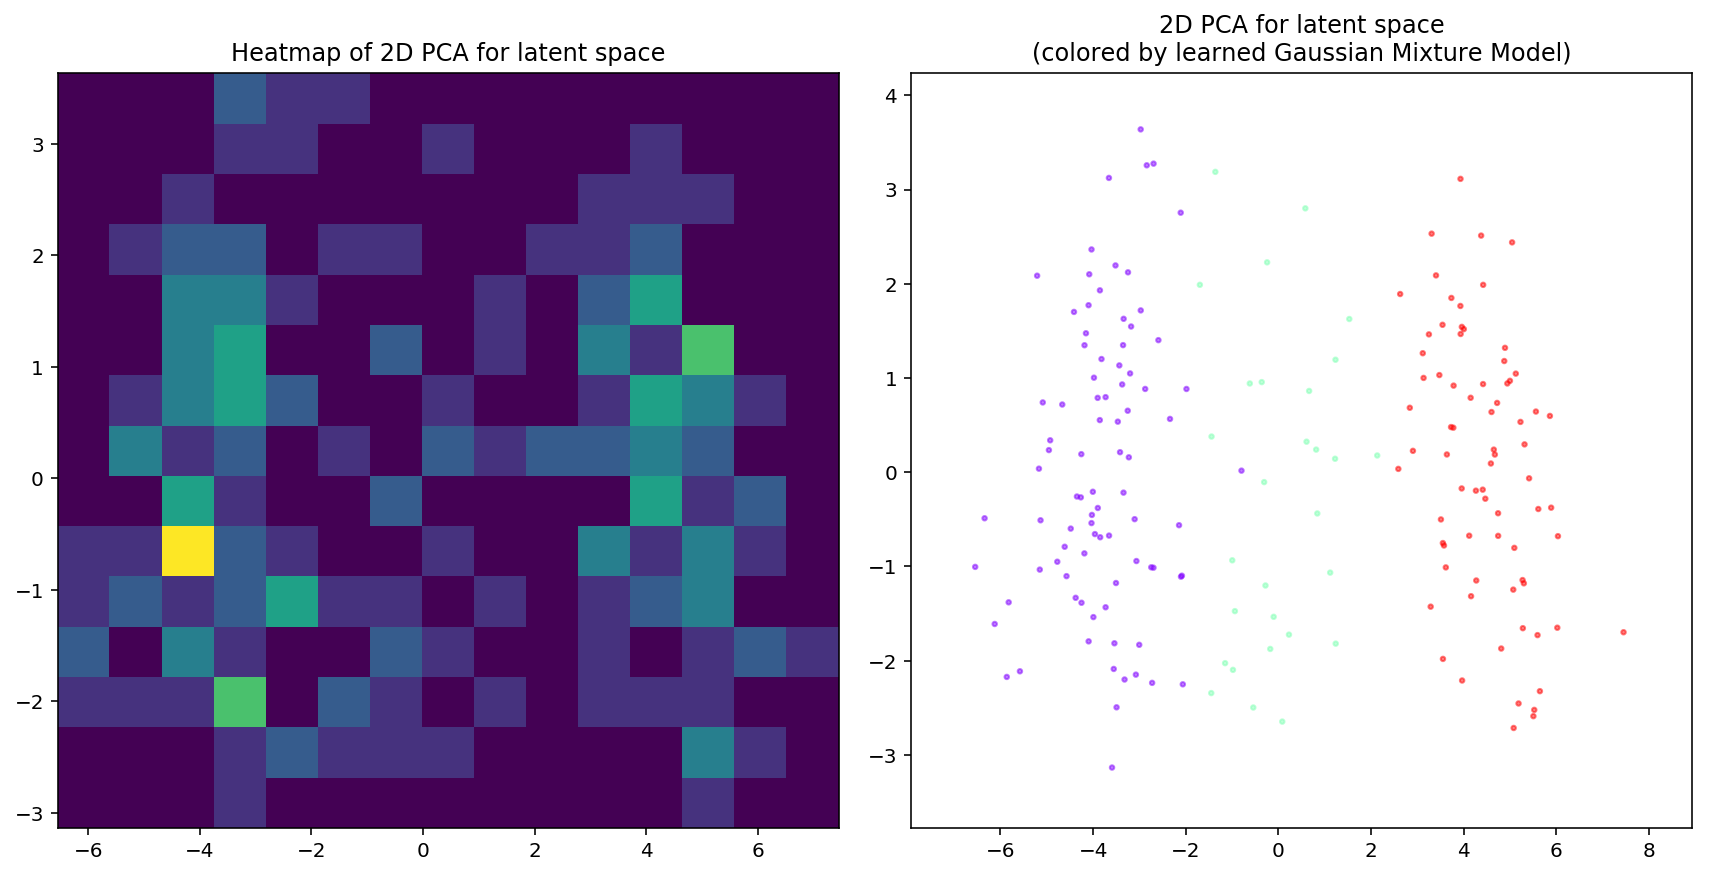

In [299]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.hist2d(pca_mu2[:,0], pca_mu2[:,1], bins=15)
plt.title('Heatmap of 2D PCA for latent space')

plt.subplot(122)
plt.scatter(pca_mu2[:,0], pca_mu2[:,1],
            c=assign_samp, 
            cmap='rainbow', s=5, alpha=0.5)

plt.scatter(pca_mu2[:,0], pca_mu2[:,1],
            c=assign_samp, 
            cmap='rainbow', 
            s=1000*np.square(np.mean(latent3000.z_sigma.numpy(),axis=1)), alpha=0.0001,)

plt.tight_layout()
plt.title('2D PCA for latent space\n(colored by learned Gaussian Mixture Model)');

### Factor loadings of latent space

In [300]:
mean_latent_vector = (
    pd.concat(
    [pd.DataFrame({'cluster':assign_samp}),
    pd.DataFrame(latent3000.z2_mu.numpy())], 
    axis=1)
    .groupby('cluster')
    .mean())

In [301]:
[x.shape for x in latent3000.get_weights()]

[(3, 3, 1, 16),
 (16,),
 (3, 3, 16, 32),
 (32,),
 (1584, 256),
 (256,),
 (272, 62),
 (62,),
 (190, 16),
 (190, 16),
 (190, 16),
 (190, 16)]

In [302]:
mean_latent_vector.shape

(3, 16)

In [303]:
latent3000.get_weights()[-8][-16:].shape

(16, 256)

In [304]:
cluster_y_dist = tf.nn.softmax(
    (mean_latent_vector
    @ latent3000.get_weights()[-8][-16:]).values, 
    axis=1)

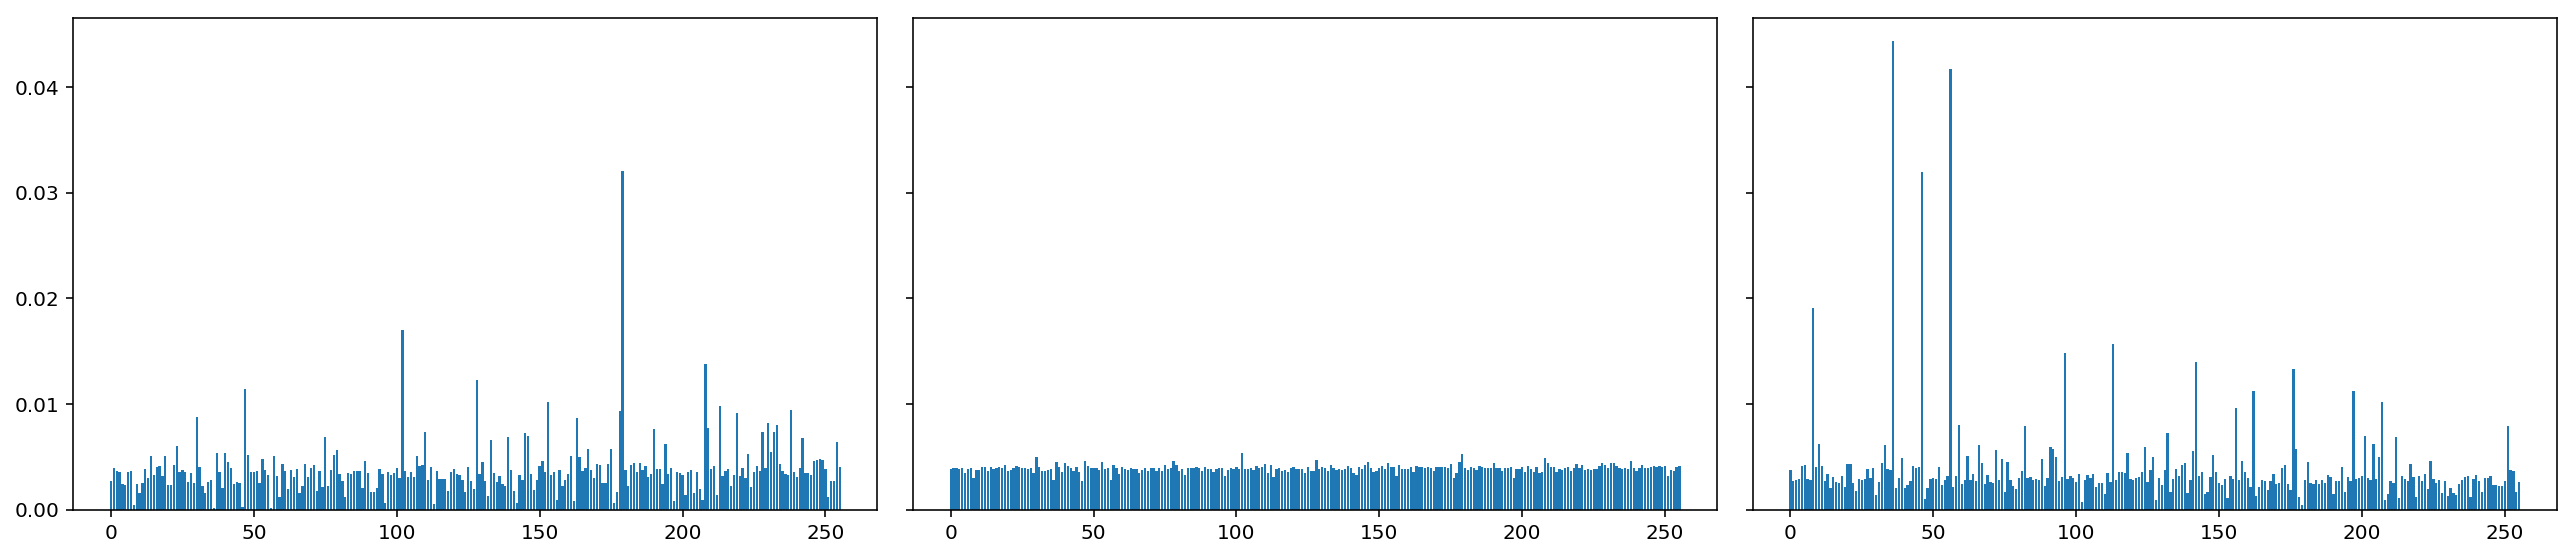

In [305]:
fig, axes = plt.subplots(1,3,figsize=(18,4), sharey=True)
for i in range(3):
    axes[i].bar(range(256),cluster_y_dist[i][:256])
plt.tight_layout();

### Look at letters and numbers across space

In [229]:
from functools import reduce


z_mu_df = pd.DataFrame(pca_mu)
numbers_count = sum(distribution_of_labels[i] for i in range(10)).rename('nums')
letters_count = sum(distribution_of_labels[i] for i in range(10, 62)).rename('lets')
lower_letters_count = sum(distribution_of_labels[i] for i in range(10, 36)).rename('lower_lets')
upper_letters_count = sum(distribution_of_labels[i] for i in range(36, 62)).rename('upper_lets')
df = pd.concat([numbers_count, letters_count, lower_letters_count, upper_letters_count, z_mu_df], 1)

num_bins = 15
df['dim1_bin'] = pd.cut(df[1], bins=num_bins).apply(lambda x: x.right)
df['dim2_bin'] = pd.cut(df[0], bins=num_bins).apply(lambda x: x.right)

In [230]:
df.head()

,nums,lets,lower_lets,upper_lets,0,1,dim1_bin,dim2_bin
0,107.0,231.0,122.0,109.0,-1.323338,0.276668,0.436,-1.073
1,107.0,250.0,119.0,131.0,-1.581027,-0.491374,-0.376,-1.356
2,105.0,207.0,118.0,89.0,-1.784499,0.178448,0.273,-1.640
3,107.0,225.0,110.0,115.0,-1.008429,-0.450429,-0.376,-0.790
4,108.0,207.0,83.0,124.0,-0.807990,0.021511,0.111,-0.790


In [231]:
df['cluster'] = assign_samp
df['number_prop'] = df['nums'] / (df['nums']+df['lets'])
df['letter_prop'] = df['lets'] / (df['nums']+df['lets'])
df['lower_let_prop'] = df['lower_lets'] / (df['lets'])
df['upper_let_prop'] = df['upper_lets'] / (df['lets'])
df.groupby('cluster')[['number_prop', 'letter_prop']].mean().round(3)

,number_prop,letter_prop
cluster,,
0,0.650,0.350
1,0.328,0.672
2,0.730,0.270


In [232]:
df.groupby('cluster')[[0,1]].mean()

,0,1
cluster,,
0,-0.140268,-0.018615
1,-1.009158,-0.052508
2,0.863620,0.048922


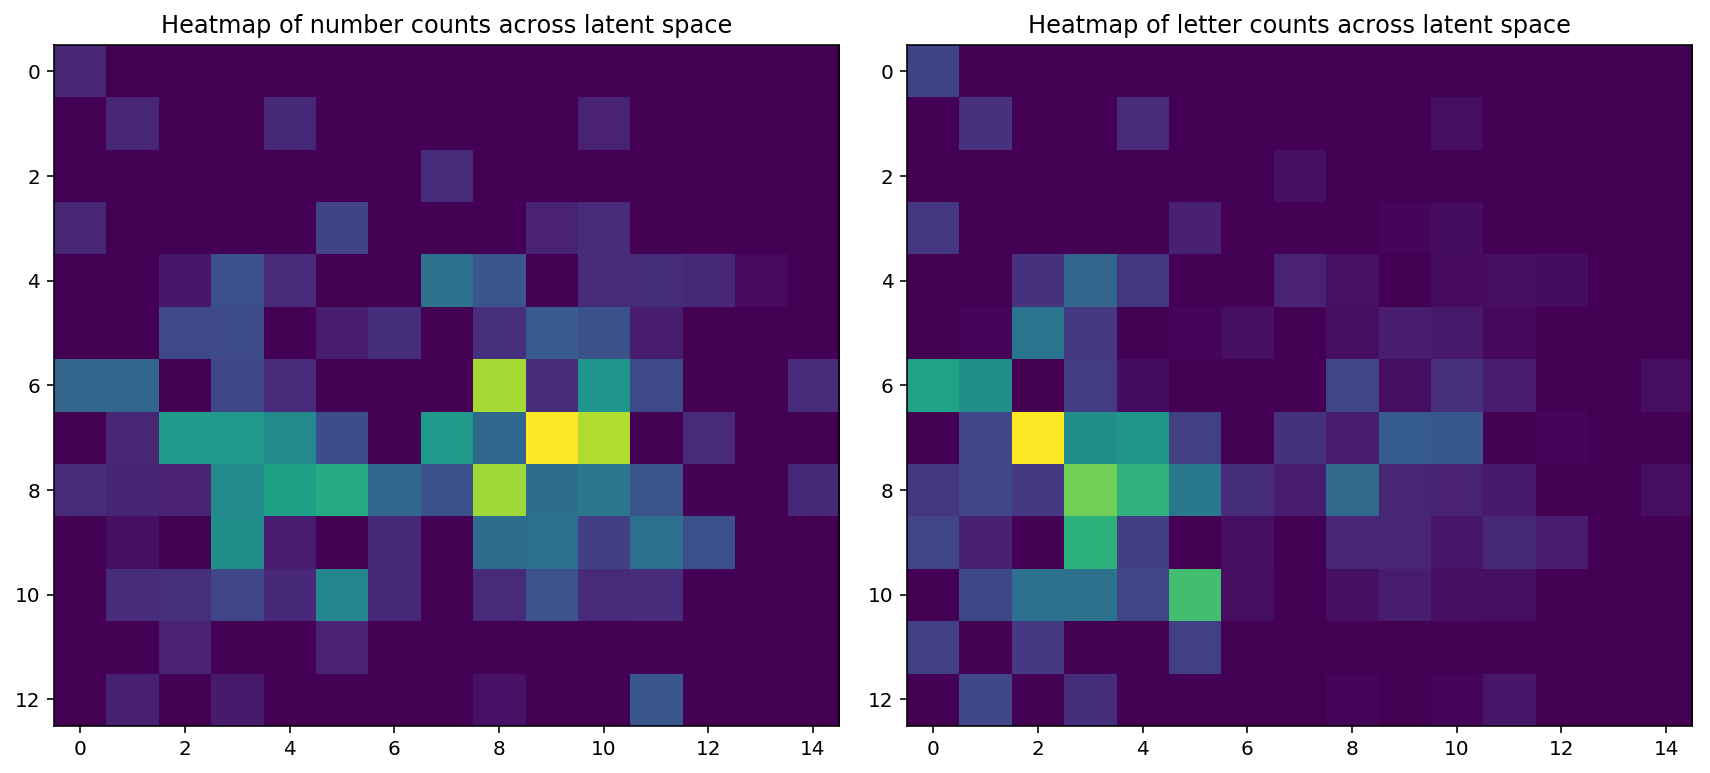

In [233]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.imshow(pd.pivot_table(
    df[['dim1_bin', 'dim2_bin', 'nums']],
    values='nums', index='dim1_bin', columns='dim2_bin', aggfunc='sum')
    .fillna(0).sort_index(axis=0,ascending=False))
plt.title('Heatmap of number counts across latent space')

plt.subplot(122)
plt.imshow(pd.pivot_table(
    df[['dim1_bin', 'dim2_bin', 'lets']],
    values='lets', index='dim1_bin', columns='dim2_bin', aggfunc='sum')
    .fillna(0).sort_index(axis=0,ascending=False))

plt.title('Heatmap of letter counts across latent space')
plt.tight_layout();

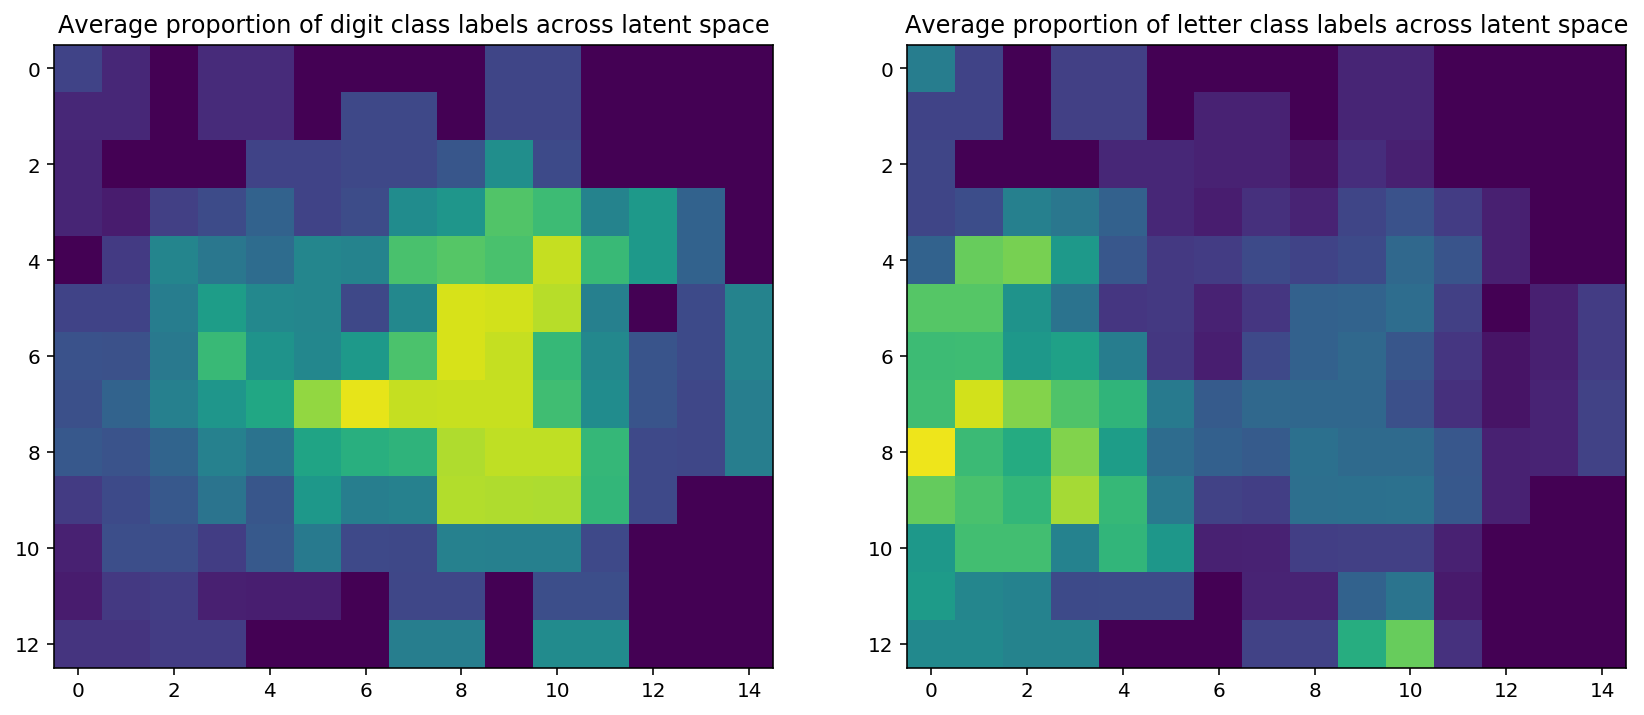

In [234]:
plt.figure(figsize=(12,6))

num_props = (
    pd.pivot_table(
        df[['dim1_bin', 'dim2_bin', 'number_prop']],
        values='number_prop', 
        index='dim1_bin', 
        columns='dim2_bin', 
        aggfunc='mean')
    .fillna(0)
    .sort_index(axis=0,ascending=False)
    .values)
num_props = np.expand_dims(np.expand_dims(num_props, axis=0), axis=-1)
num_props = tf.keras.layers.AveragePooling2D(pool_size=2, strides=1, padding='same')(num_props)

plt.subplot(121)
plt.imshow(np.squeeze(num_props), vmin=0, vmax=0.8)
plt.title('Average proportion of digit class labels across latent space')


let_props = (
    pd.pivot_table(
        df[['dim1_bin', 'dim2_bin', 'letter_prop']],
        values='letter_prop', 
        index='dim1_bin', 
        columns='dim2_bin', 
        aggfunc='mean')
    .fillna(0)
    .sort_index(axis=0,ascending=False)
    .values)
let_props = np.expand_dims(np.expand_dims(let_props, axis=0), axis=-1)
let_props = tf.keras.layers.AveragePooling2D(pool_size=2, strides=1, padding='same')(let_props)

plt.subplot(122)
plt.imshow(np.squeeze(let_props), vmin=0, vmax=0.8)
plt.title('Average proportion of letter class labels across latent space')

plt.tight_layout();

### Look at letters and numbers across z2 space

In [235]:
from functools import reduce


z_mu_df = pd.DataFrame(pca_mu2)
numbers_count = sum(distribution_of_labels[i] for i in range(10)).rename('nums')
letters_count = sum(distribution_of_labels[i] for i in range(10, 62)).rename('lets')
lower_letters_count = sum(distribution_of_labels[i] for i in range(10, 36)).rename('lower_lets')
upper_letters_count = sum(distribution_of_labels[i] for i in range(36, 62)).rename('upper_lets')
df = pd.concat([numbers_count, letters_count, lower_letters_count, upper_letters_count, z_mu_df], 1)

num_bins = 20
df['dim1_bin'] = pd.cut(df[1], bins=num_bins).apply(lambda x: x.right)
df['dim2_bin'] = pd.cut(df[0], bins=num_bins).apply(lambda x: x.right)

In [236]:
df.head()

,nums,lets,lower_lets,upper_lets,0,1,dim1_bin,dim2_bin
0,107.0,231.0,122.0,109.0,3.912835,1.051043,1.1890,3.914
1,107.0,250.0,119.0,131.0,6.183827,0.377686,0.6100,6.641
2,105.0,207.0,118.0,89.0,5.554475,0.665957,0.9000,5.959
3,107.0,225.0,110.0,115.0,5.413068,-0.186143,0.0316,5.959
4,108.0,207.0,83.0,124.0,3.684805,0.418030,0.6100,3.914


In [237]:
df['cluster'] = assign_samp
df['number_prop'] = df['nums'] / (df['nums']+df['lets'])
df['letter_prop'] = df['lets'] / (df['nums']+df['lets'])
df['lower_let_prop'] = df['lower_lets'] / (df['lets'])
df['upper_let_prop'] = df['upper_lets'] / (df['lets'])
df.groupby('cluster')[['number_prop', 'letter_prop']].mean().round(3)

,number_prop,letter_prop
cluster,,
0,0.650,0.350
1,0.328,0.672
2,0.730,0.270


In [238]:
df.groupby('cluster')[[0,1]].mean()

,0,1
cluster,,
0,0.220811,-0.009237
1,4.434314,-0.009121
2,-3.655471,0.010613


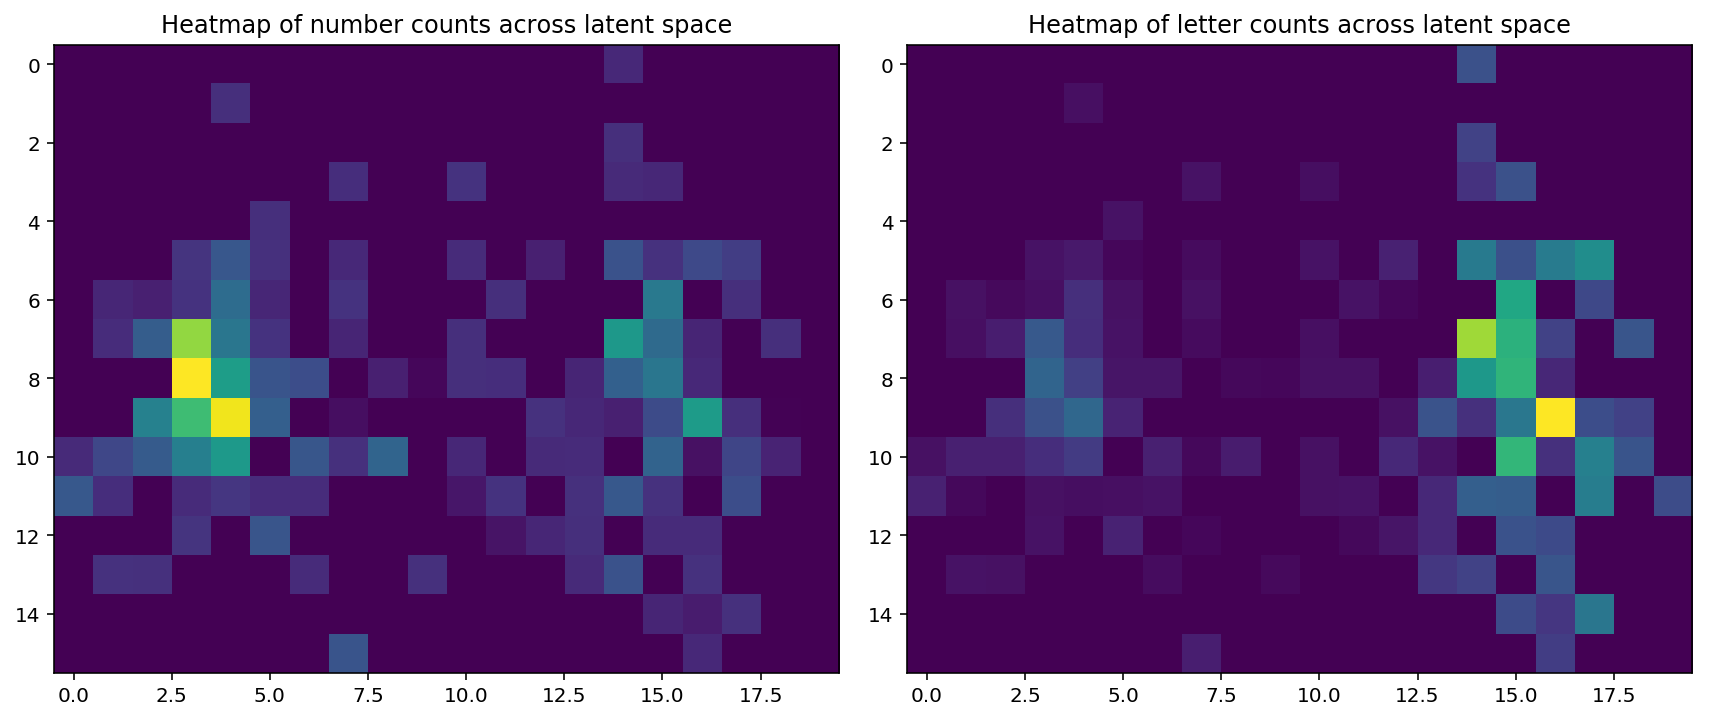

In [239]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.imshow(pd.pivot_table(
    df[['dim1_bin', 'dim2_bin', 'nums']],
    values='nums', index='dim1_bin', columns='dim2_bin', aggfunc='sum')
    .fillna(0).sort_index(axis=0,ascending=False))
plt.title('Heatmap of number counts across latent space')

plt.subplot(122)
plt.imshow(pd.pivot_table(
    df[['dim1_bin', 'dim2_bin', 'lets']],
    values='lets', index='dim1_bin', columns='dim2_bin', aggfunc='sum')
    .fillna(0).sort_index(axis=0,ascending=False))

plt.title('Heatmap of letter counts across latent space')
plt.tight_layout();

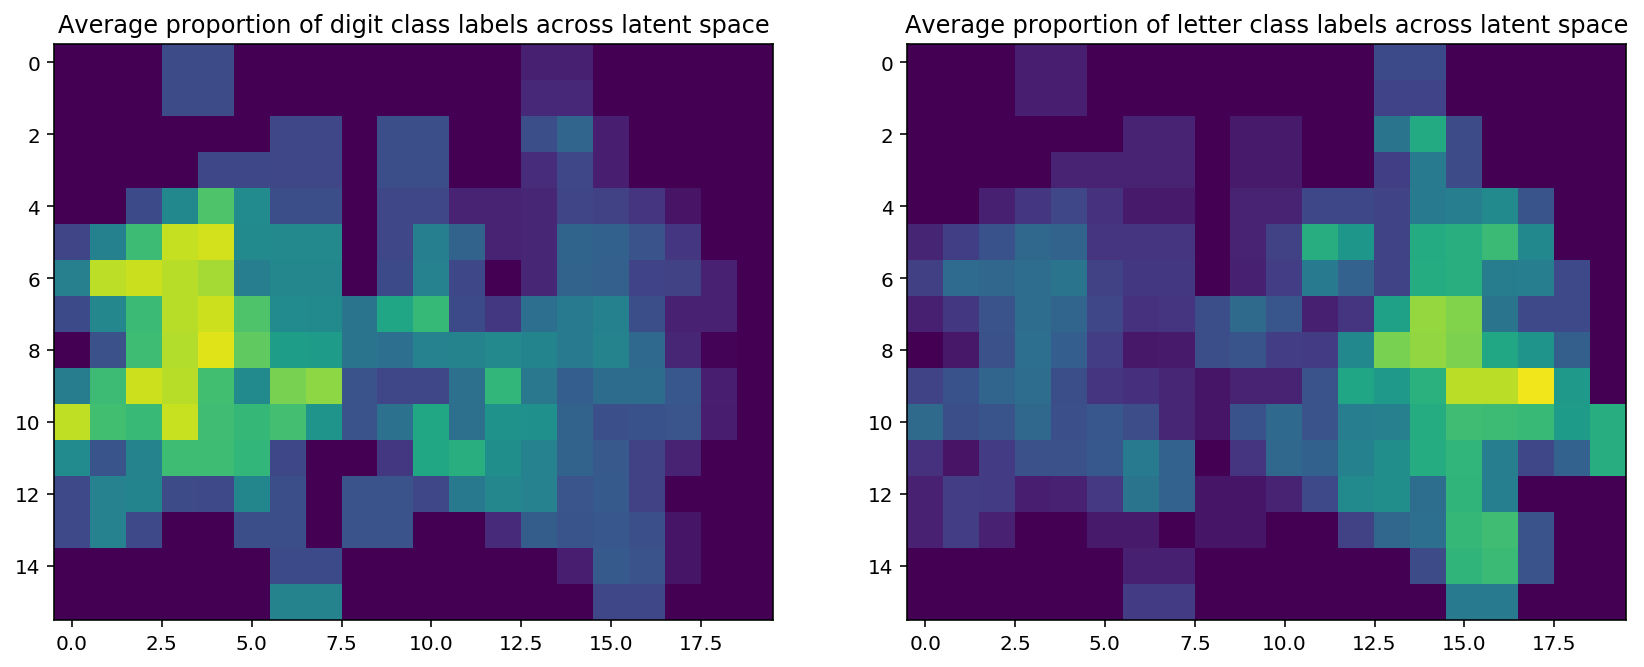

In [240]:
plt.figure(figsize=(12,6))

num_props = (
    pd.pivot_table(
        df[['dim1_bin', 'dim2_bin', 'number_prop']],
        values='number_prop', 
        index='dim1_bin', 
        columns='dim2_bin', 
        aggfunc='mean')
    .fillna(0)
    .sort_index(axis=0,ascending=False)
    .values)
num_props = np.expand_dims(np.expand_dims(num_props, axis=0), axis=-1)
num_props = tf.keras.layers.AveragePooling2D(pool_size=2, strides=1, padding='same')(num_props)

plt.subplot(121)
plt.imshow(np.squeeze(num_props), vmin=0, vmax=0.8)
plt.title('Average proportion of digit class labels across latent space')


let_props = (
    pd.pivot_table(
        df[['dim1_bin', 'dim2_bin', 'letter_prop']],
        values='letter_prop', 
        index='dim1_bin', 
        columns='dim2_bin', 
        aggfunc='mean')
    .fillna(0)
    .sort_index(axis=0,ascending=False)
    .values)
let_props = np.expand_dims(np.expand_dims(let_props, axis=0), axis=-1)
let_props = tf.keras.layers.AveragePooling2D(pool_size=2, strides=1, padding='same')(let_props)

plt.subplot(122)
plt.imshow(np.squeeze(let_props), vmin=0, vmax=0.8)
plt.title('Average proportion of letter class labels across latent space')

plt.tight_layout();

### Sample z

In [932]:
labels = list(string.digits +  string.ascii_uppercase + string.ascii_lowercase)
labels_dict = {i: labels[i] for i in range(62)}
num2label = lambda arr: list(map(lambda x: labels_dict[x], arr))

In [782]:
#potentially expensive
samp = latent3000.call_sample_z(x_test[:10000], gid_test[:10000], num_samples=20)

In [742]:
# sampling all writers!
samp = latent3000.call_sample_z(np.tile(x_test[939], 3500).reshape((3500,784)), 
                                np.unique(gid_test), 
                                num_samples=20)

In [535]:
samp[0].shape

TensorShape([20, 3500, 62])

In [783]:
scores, log_importance_weights = samp
scores, log_importance_weights = scores.numpy(), log_importance_weights.numpy()
importance_weights = tf.exp(log_importance_weights)

In [784]:
scores.shape, log_importance_weights.shape

((20, 10000, 62), (20, 10000))

In [274]:
scores[:1]

array([[[-11.831341  , -25.299435  ,  21.888866  , ..., -24.049976  ,
         -19.501926  ,   0.29663718],
        [-11.930349  ,  -9.837076  , -10.438313  , ..., -12.924095  ,
         -15.067887  , -12.041747  ],
        [  3.015101  , -19.006205  , -15.754461  , ..., -37.126446  ,
         -18.044186  , -22.889631  ],
        ...,
        [-22.509111  , -20.590395  , -11.858428  , ..., -12.909127  ,
          -4.193124  , -32.647022  ],
        [ -9.208007  ,   0.6572585 , -17.09482   , ..., -13.733653  ,
          -9.922538  , -16.492727  ],
        [-19.980482  ,  -9.441158  , -24.363304  , ..., -17.432398  ,
         -24.51268   , -19.126896  ]]], dtype=float32)

In [394]:
def stable_softmax(arr, axis=2):
    np_kwargs = {'axis':axis, 'keepdims':True}
    num = np.exp(arr - np.max(arr, **np_kwargs))
    denom = np.sum(np.exp(arr - np.max(arr, **np_kwargs)), **np_kwargs)
    return num/denom

def stable_mod_softmax_product(arr, logr, axis=2):
    np_kwargs = {'axis':axis, 'keepdims':True}
    num = np.exp(arr - np.max(arr, **np_kwargs) + logr)
    denom = np.sum(np.exp(arr - np.max(arr, **np_kwargs)), **np_kwargs)
    return num/denom

#stable_softmax = np.vectorize(stable_softmax)
#stable_mod_softmax_product = np.vectorize(stable_mod_softmax_product)

In [317]:
np.array([[1,1,1], [1,2,3]]).shape

(2, 3)

In [324]:
np.array([[[1,1,1, 5], 
           [1,1,4,5],
                                      [1,2,3,5]],
                                     [[1,1,1,5],
                                      [1,2,1,5],
                                      [1,2,3,5]]]).shape

(2, 3, 4)

In [415]:
log_imp_weights = np.expand_dims(np.array(
    [[1,3,-3],
     [3,4,-6]]), axis=-1)
logs = np.array([[[1,1,1,1], 
                  [1,1,4,5],
                [1,2,3,5]],
                 [[1,1,1,5],
                  [1,2,1,5],
                  [1,2,3,5]]])
stable_mod_softmax_product(logs, log_imp_weights).round()

array([[[ 1.,  1.,  1.,  1.],
        [ 0.,  0.,  5., 14.],
        [ 0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., 19.],
        [ 1.,  3.,  1., 50.],
        [ 0.,  0.,  0.,  0.]]])

In [419]:
log_imp_weights = np.array(
    [[1,-2,-3],
     [3,-1,200]])
logs = np.array([[[1,1,1,1], 
                  [1,1,4,5],
                  [1,2,3,5]],
                 [[1,1,1,2],
                  [1,2,1,2],
                  [1,2,3,2]]])
numerator = (
    np.sum(stable_softmax(logs, axis=2) * np.expand_dims(np.exp(log_imp_weights), axis=-1), axis=0))

imp_weight_sum = np.expand_dims(np.sum(np.exp(log_imp_weights), axis=0), axis=1)
samp_imp = numerator / imp_weight_sum

In [422]:
np.exp(log_imp_weights)

array([[2.71828183e+00, 1.35335283e-01, 4.97870684e-02],
       [2.00855369e+01, 3.67879441e-01, 7.22597377e+86]])

In [417]:
samp_imp.round(1)

array([[0.2, 0.2, 0.2, 0.4],
       [0.1, 0.3, 0.2, 0.5],
       [0.1, 0.2, 0.5, 0.2]])

(samples, batch, num_classes)

In [315]:
log_importance_weights.shape

(20, 10000)

### maybe just keep normal calc

# note: change to drop in approx

In [787]:
numerator = (
    tf.reduce_sum(scores * tf.expand_dims(tf.exp(log_importance_weights), axis=2), axis=0))

imp_weight_sum = np.expand_dims(tf.reduce_sum(importance_weights, axis=0), axis=1)

#
#samp_imp = numerator / imp_weight_sum
samp_imp = tf.reduce_mean(scores, axis=0)

In [781]:
scores.shape

(20, 3500, 62)

In [713]:
np.percentile(log_importance_weights, 50, axis=0)

array([-8.15072823, -8.94680977, -9.31106949, ..., -5.42580223,
       -4.74206352, -4.83597183])

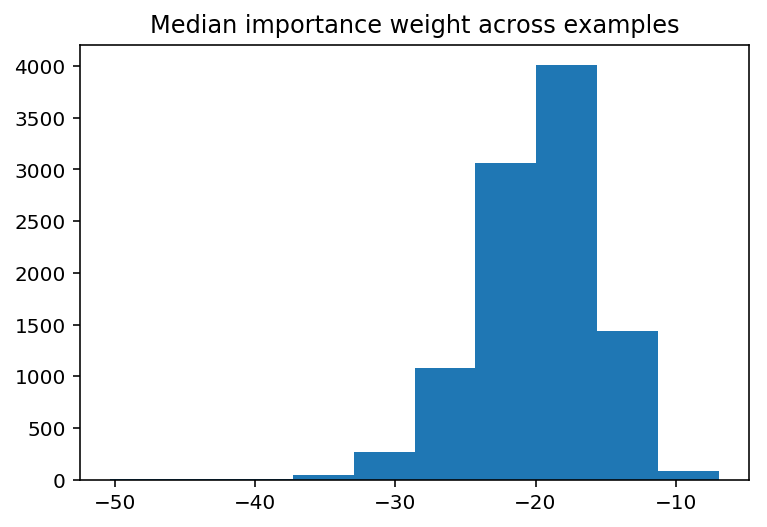

In [714]:
plt.hist(np.percentile(log_importance_weights, 10, axis=0))
plt.title('Median importance weight across examples');

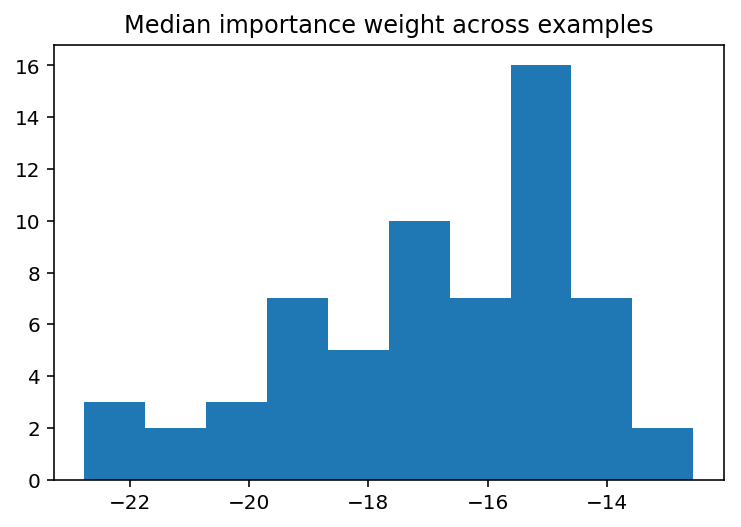

In [715]:
plt.hist(np.percentile(np.log(numerator), 50, axis=0))
plt.title('Median importance weight across examples');

In [427]:
imp_weight_sum

array([[2.4337985e-01],
       [5.9491438e-01],
       [3.0033533e+03],
       ...,
       [8.7482756e-01],
       [4.7636604e+00],
       [1.9009951e+00]], dtype=float32)

In [271]:
tf.reduce_sum(samp_imp, axis=1).numpy().round()

array([82., 34.,  0., ..., 23.,  4., 11.], dtype=float32)

<BarContainer object of 62 artists>

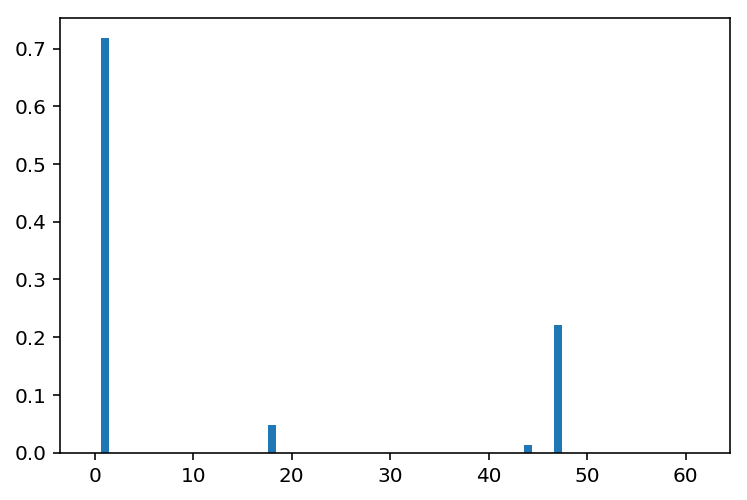

In [716]:
plt.bar(range(62), samp_imp[10])

In [ ]:
z_samp = latent3000.construct_mean_field_posterior(4).sample(20)

In [61]:
p_y_giv_xz = latent3000.call_sample_z(x_train[:100], gid_train[:100], num_samples=20)

In [63]:
x_train[:100].shape, gid_train[:100].shape

((100, 784), (100,))

In [84]:
np.array([-3.,-2.,-1.])

array([-3., -2., -1.])

In [32]:
samp[:,:100,:].shape

TensorShape([30, 100, 62])

In [189]:
A = np.random.choice(20, 5, replace=False)
A

array([12, 11,  7,  1,  4])

In [268]:
def get_k_largest_elements(arr, k):
    return arr[np.argpartition]

In [265]:
np.partition(A, np.arange(-3,-1))[-3:]

array([ 7, 11, 12])

In [205]:
A[np.argpartition(A, [-2,-3])[-3:]]

array([ 7, 11, 12])

In [210]:
np.argpartition(A, -3)[-3:]

array([2, 0, 1])

In [150]:
tf.reduce_mean(samp.numpy(), axis=0)[0]

AttributeError: 'tuple' object has no attribute 'numpy'

In [ ]:
#.apply(num2label)

In [ ]:
#'1':np.partition(row, -4)[-4:]}

In [93]:

softmax_out = tf.nn.softmax(tf.reduce_mean(samp[0], axis=0), axis=1).numpy()[:1000]

In [ ]:
np.sort()

In [ ]:
samp_imp

In [788]:
def sorted_argpartition():
    pass
    

argpart = np.apply_along_axis(lambda row: np.argpartition(row, np.arange(-4,-1))[-4:][::-1], 1, 
                              samp_imp)
values = np.apply_along_axis(lambda row: np.sort(row)[-4:][::-1], 1, samp_imp)
softmax_df = pd.concat([
    pd.DataFrame(argpart).stack().rename('label_index'), 
    pd.DataFrame(values).stack().rename('softmax')], axis=1)

softmax_df['label_index'] = softmax_df[['label_index']].apply(num2label)
softmax_df = softmax_df.reset_index(level=1,drop=True).set_index('label_index', append=True)['softmax']
softmax_df = softmax_df.round(2)[softmax_df > 0.01]

In [789]:
(softmax_df.loc[np.random.choice(range(1000), size=10)]
 .groupby(level=0)
 .filter(lambda s: len(s) > 1)).head(20)

     label_index
201  3              0.96
     s              0.02
327  X              0.84
     x              0.16
413  k              0.61
     K              0.35
     X              0.02
     x              0.01
886  0              0.71
     O              0.25
     o              0.03
959  1              0.84
     l              0.12
     I              0.04
Name: softmax, dtype: float32

In [747]:
(pd.DataFrame(
    tf.nn.softmax(tf.reduce_mean(samp.numpy(), axis=0)))
 .T.apply(num2label).stack()
 .groupby(level=0)
 .value_counts(normalize=True)).groupby(level=0).size().value_counts()

AttributeError: 'tuple' object has no attribute 'numpy'

In [565]:
plt.bar(range(62),tf.nn.softmax(tf.reduce_mean(samp.numpy(), axis=0)[10]))
plt.title('Softmax output across labels');

AttributeError: 'tuple' object has no attribute 'numpy'

In [720]:
uncertainty_df = (pd.DataFrame(
    samp.numpy().argmax(axis=2))
 .T.apply(num2label).stack()
 .groupby(level=0)
 .value_counts(normalize=True))

(uncertainty_df.loc[np.random.choice(range(10000), size=100)]
 .groupby(level=0)
 .filter(lambda s: len(s) > 1))

AttributeError: 'tuple' object has no attribute 'numpy'

,predicted prob
label_index,
k,0.61
K,0.35
X,0.02
x,0.01


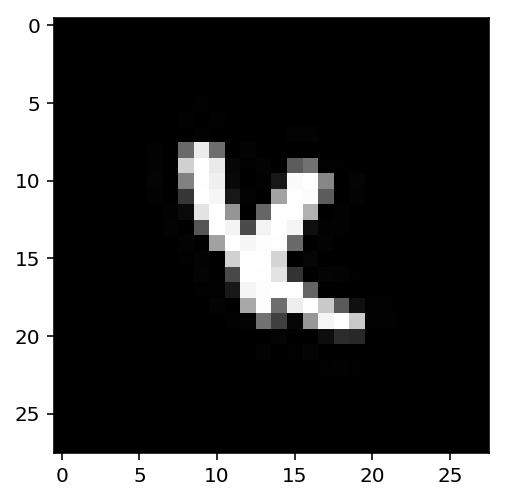

In [790]:
idx=413
display(softmax_df.loc[idx].rename('predicted prob').to_frame())
plt.imshow(
    x_test[idx].reshape((28,28)), 
    cmap='Greys');

In [748]:
softmax_df = softmax_df.to_frame()

softmax_df = (
    pd.merge(softmax_df.rename_axis(['id', 'label_index']), 
             pd.Series(assign_samp.astype(np.int64)).rename_axis('id').rename('cluster'), 
             left_index=True, right_index=True))

softmax_df['softmax'] = softmax_df['softmax'].astype(float)

In [749]:
softmax_df.groupby('cluster').apply(lambda df: df['softmax'].unstack()).groupby(level=0).mean().round(3)

,C,c,e
cluster,,,
0,0.586,0.251,0.162
1,0.804,0.064,0.131
2,0.705,0.141,0.153


softmax  cluster
gid  label                  
0    C         0.81        1
     e         0.13        1
     c         0.06        1
10   C         0.81        1
     e         0.12        1
     c         0.06        1
2551 C         0.60        0
     c         0.24        0
     e         0.16        0

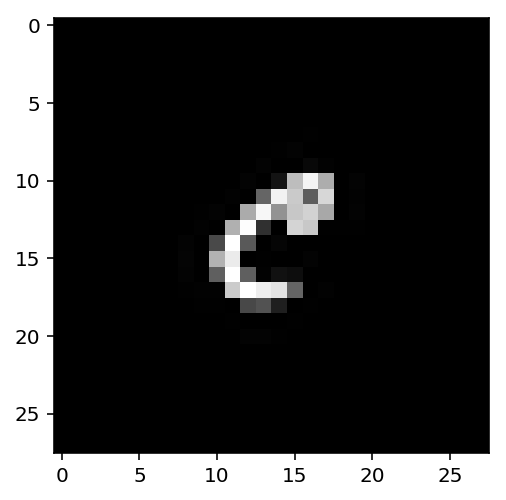

In [755]:
idx=[0,10,2551]
display(softmax_df.loc[idx].rename_axis(['gid','label'], axis='index'))
plt.imshow(
    x_test[939].reshape((28,28)), 
    cmap='Greys');

In [768]:
label_df = softmax_df.unstack().fillna(0)

merge_df = pd.concat([label_df['softmax'], z_mu_df], axis=1)

In [773]:
merge_df['dim1_bin'] = pd.cut(df[1], bins=30).apply(lambda x: x.right)
merge_df['dim2_bin'] = pd.cut(df[0], bins=30).apply(lambda x: x.right)

In [774]:
merge_df.head()

,C,e,c,0,1,dim1_bin,dim2_bin
0,0.81,0.13,0.06,-2.535095,0.117625,0.1290,-2.532
1,0.83,0.12,0.05,-2.522457,0.072561,0.0801,-2.274
2,0.83,0.13,0.04,-2.988214,0.127521,0.1290,-2.791
3,0.83,0.12,0.05,-2.957801,-0.174836,-0.1640,-2.791
4,0.78,0.13,0.09,-1.540960,-0.022707,-0.0176,-1.498


In [761]:
pd.pivot_table(
    merge_df[['dim1_bin', 'dim2_bin', 'l']],
    values='l', index='dim1_bin', columns='dim2_bin', aggfunc='mean')

KeyError: "['l'] not in index"

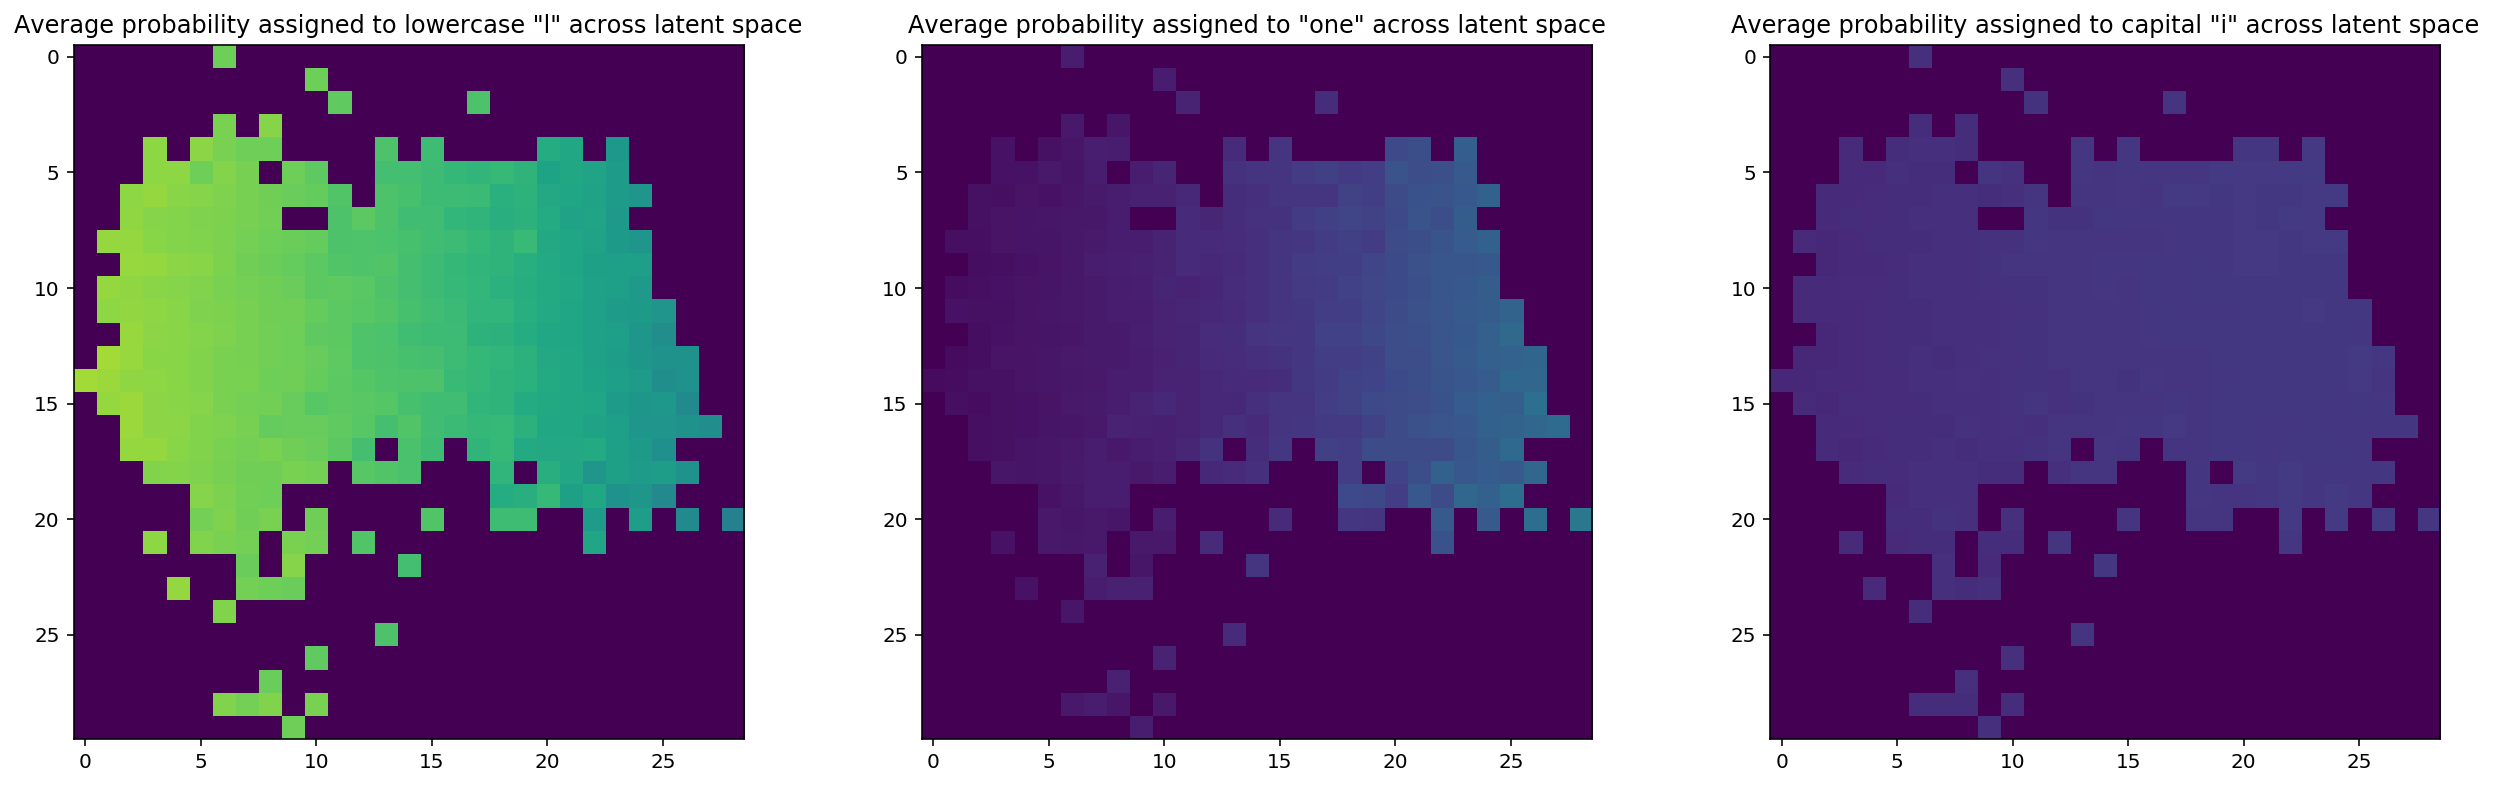

In [775]:
plt.figure(figsize=(18,6))

plt.subplot(131)
plt.imshow(pd.pivot_table(
    merge_df[['dim1_bin', 'dim2_bin', 'C']],
    values='C', index='dim1_bin', columns='dim2_bin', aggfunc='mean')
    .fillna(0), vmin=0, vmax=1)
plt.title('Average probability assigned to lowercase "l" across latent space')

plt.subplot(132)
plt.imshow(pd.pivot_table(
    merge_df[['dim1_bin', 'dim2_bin', 'c']],
    values='c', index='dim1_bin', columns='dim2_bin', aggfunc='mean')
    .fillna(0), vmin=0, vmax=1)

plt.title('Average probability assigned to "one" across latent space')

plt.subplot(133)
#tf.keras.layers.AveragePooling2D(pool_size=2, strides=1, padding='same')
plt.imshow(pd.pivot_table(
    merge_df[['dim1_bin', 'dim2_bin', 'e']],
    values='e', index='dim1_bin', columns='dim2_bin', aggfunc='mean')
    .fillna(0), vmin=0, vmax=1)

plt.title('Average probability assigned to capital "i" across latent space')
plt.tight_layout();

### Calibration test

In [791]:
plt.hist(tf.nn.softmax(tf.reduce_mean(samp, axis=0)).numpy()[:1000].max(axis=1), bins=30);

InvalidArgumentError: Shapes of all inputs must match: values[0].shape = [20,10000,62] != values[1].shape = [20,10000] [Op:Pack] name: packed

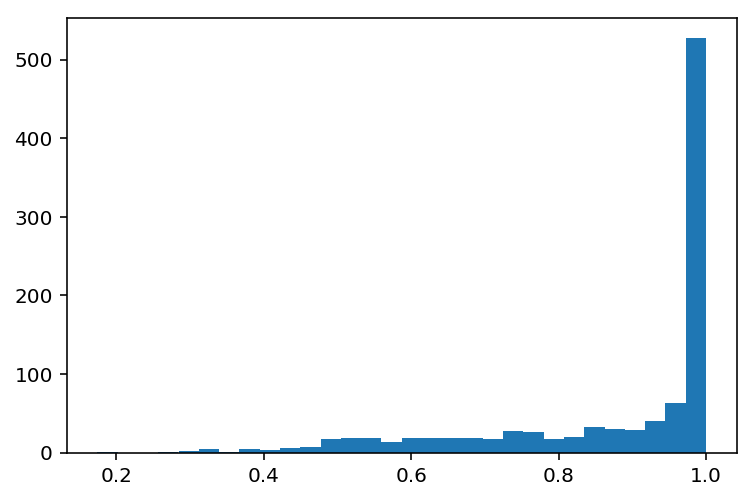

In [792]:
plt.hist(samp_imp.numpy()[:1000].max(axis=1), bins=30);

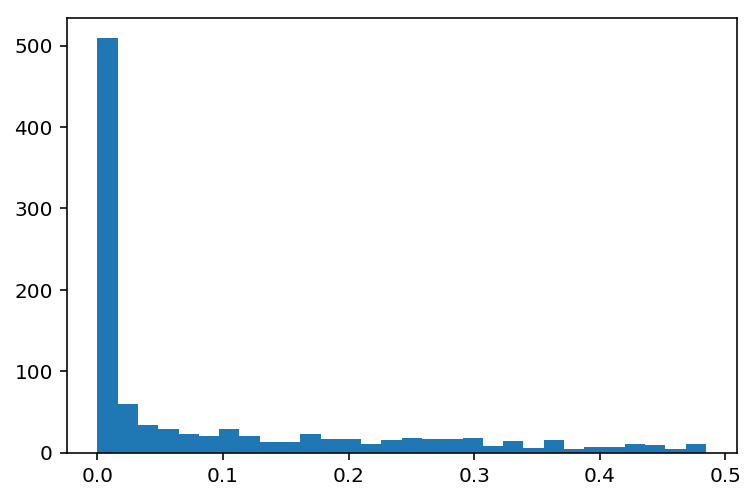

In [793]:
plt.hist(np.partition(samp_imp.numpy()[:1000], -2, axis=1)[:,-2], bins=30);

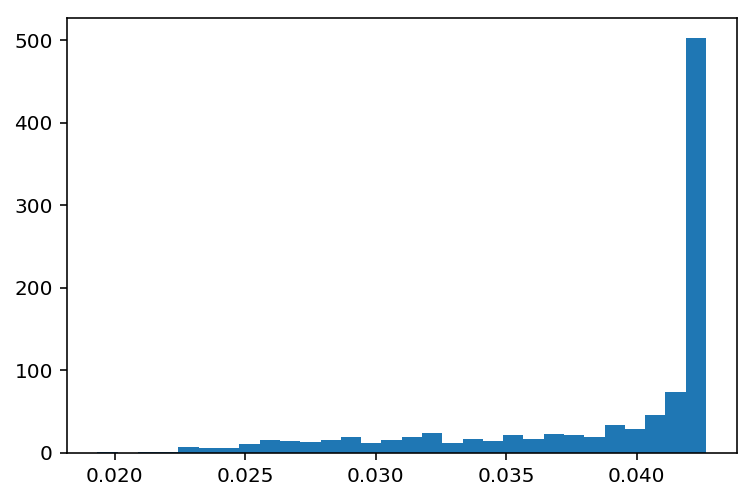

In [794]:
plt.hist(tf.nn.softmax(latent3000(x_test[:1000], gid_test[:1000])).numpy().max(axis=1), bins=30);

In [156]:
calib_df = pd.concat([
    pd.Series(tf.nn.softmax(tf.reduce_mean(samp, axis=0)).numpy()[:1000].max(axis=1)),
    pd.Series(tf.nn.softmax(tf.reduce_mean(samp, axis=0)).numpy()[:1000].argmax(axis=1)),
          pd.Series(y_test[:1000].argmax(axis=1))], axis=1)

InvalidArgumentError: Shapes of all inputs must match: values[0].shape = [20,10000,62] != values[1].shape = [20,10000] [Op:Pack] name: packed

In [158]:
calib_df = pd.concat([
    pd.Series(samp_imp.numpy().max(axis=1)),
    pd.Series(samp_imp.numpy().argmax(axis=1)),
          pd.Series(y_test.argmax(axis=1))], axis=1)

In [234]:
calib_df = pd.concat([
    pd.Series(tf.nn.softmax(latent3000(x_test[:1000], gid_test[:1000])).numpy().max(axis=1)),
    pd.Series(tf.nn.softmax(latent3000(x_test[:1000], gid_test[:1000])).numpy().argmax(axis=1)),
          pd.Series(y_test[:1000].argmax(axis=1))], axis=1)

In [162]:
from sklearn.metrics import accuracy_score

In [160]:
stretch_range = lambda x: 1-np.log(1-x)
stretch_range_inv = lambda x: 1-np.exp(1-x)

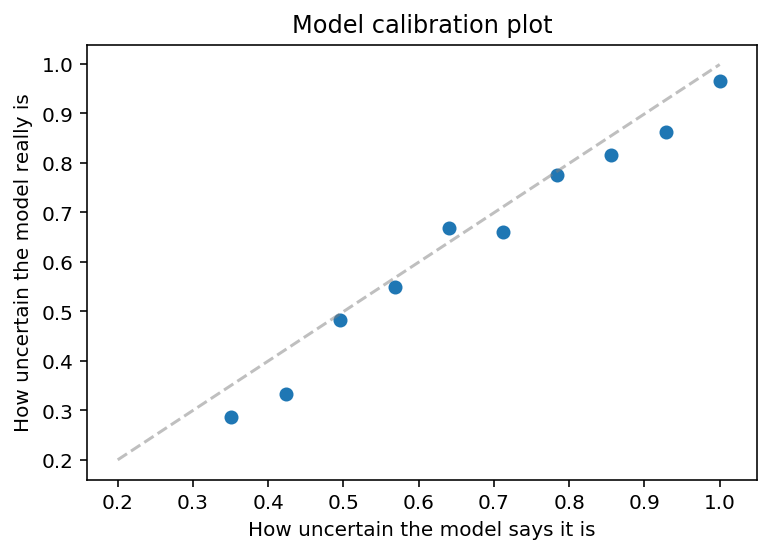

In [163]:
calib_df['calib_bin'] = (
    pd.cut(calib_df[0], bins=10)
    .apply(lambda x: x.right))
calib = (calib_df.groupby('calib_bin')
         .apply(lambda df: accuracy_score(df[2], df[1]))
         .reset_index())
plt.scatter(calib.values[:,0], calib.values[:,1])
plt.plot(np.linspace(0.2,1,2), np.linspace(0.2,0.999,2), alpha=0.5, color='grey', linestyle='dashed')
plt.title('Model calibration plot')
plt.xlabel('How uncertain the model says it is')
plt.ylabel('How uncertain the model really is');

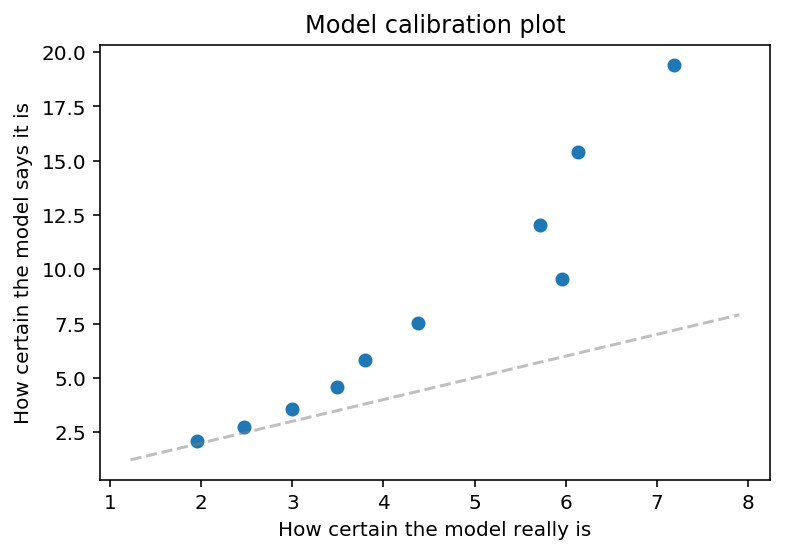

In [201]:
calib_df['calib_bin'] = (
    pd.qcut(stretch_range(calib_df[0]-0.00000001), q=10)
    .apply(lambda x: x.right))
calib = (calib_df.groupby('calib_bin')
         .apply(lambda df: stretch_range(accuracy_score(df[2], df[1]))-0.00000001)
         .reset_index())
plt.scatter(calib.values[:,1], calib.values[:,0])
plt.plot( stretch_range(np.linspace(0.2,0.999,2)), stretch_range(np.linspace(0.2,0.999,2)), alpha=0.5, color='grey', linestyle='dashed' )
plt.title('Model calibration plot')
plt.ylabel('How certain the model says it is')
plt.xlabel('How certain the model really is');